In [1]:
#load the required modules
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from numba import njit, prange
import warnings

In [2]:
@njit(parallel=True)
def lightatoms_GS(r, alpha=2.0, beta=1.0, ansatz=1):
    """
    Ground state trial wavefunction for the light atoms.

    Parameters:
    - r: 2x3 array, positions of 2 electrons in 3D.
    - alpha: variational parameter
    - beta: variational parameter
    - ansatz: choose 1 or 2 for different trial wavefunctions.

    Returns:
    - psi_T: Trial wavefunction evaluated at r.
    """
    r_comb = 0.0
    for i in prange(r.shape[0]):
        r_electron = np.sqrt(np.sum(r[i]**2))
        r_comb += r_electron

    if ansatz == 1:
        psi_T = np.exp(-alpha * r_comb)

    elif ansatz == 2:
        r12 = np.sqrt(np.sum((r[0] - r[1])**2))
        psi_T = np.exp(-alpha * r_comb) * (1 + beta*r12)

    elif ansatz == 3:
        r12 = np.sqrt(np.sum((r[0] - r[1])**2))
        psi_T = np.exp(-alpha * r_comb) * np.exp(r12 / (2 * (1 + beta * r12)))

    else:
        psi_T = 0.0

    return psi_T


In [3]:
@njit(fastmath=True)
def lightatoms_GSPDF(r, alpha=2.0, beta=1.0, ansatz = 1):
    """
    This function defines the ground state trial
    Probability density function for light atoms

    Parameters:
    - r: Takes in a 2X3 matrix for position of the 2 electrons
    - alpha: Optimizing parameter (Default = 2)
    - beta: Optimizing parameter (Default = 1)
    - ansatz: choose 1 or 2 for different wave function
    Returns:
    The trial PDF for the Helium atom
    """

    wave_func = lightatoms_GS(r, alpha, beta, ansatz)
    return np.abs(wave_func)**2

In [4]:
@njit(parallel=True)
def light_loc_en(r, Z, alpha=2.0, beta=1.0, ansatz = 1):
    """
    This function defines the ground state
    Local energy for light atoms

    Parameters:
    - r: Takes in a 2X3 matrix for position of the 2 electrons
    - alpha: Optimizing parameter (Default = 2)
    - beta: Optimizing parameter (Default = 2)
    - Z: Atomic number or proton number
    - ansatz: choose a trial wavefunction
    Returns:
    The Local energy for a given light atom
    """
    GS_zero = lightatoms_GS(r, alpha, beta, ansatz)
    step = 1e-5
    KE = 0.0

    #Performing central difference method for calculation of laplacian
    for i in prange(r.shape[0]):
        for j in range(r.shape[1]):
            #forward jump
            r_plus = np.copy(r)
            r_plus[i][j] += step
            GS_plus = lightatoms_GS(r_plus, alpha, beta, ansatz)
            #backward jump
            r_minus = np.copy(r)
            r_minus[i][j] -= step
            GS_minus = lightatoms_GS(r_minus, alpha, beta, ansatz)

            KE += (GS_plus + GS_minus - 2.0 * GS_zero) / step**2

    kinetic = -0.5 * KE / GS_zero

    #Accounting for the electron-nucleus interaction
    PE1 = 0.0
    for i in prange(r.shape[0]):
        r_electron = np.sqrt(np.sum(r[i]**2))
        PE1 += -Z / r_electron

    #Accounting for the electron-electron repulsion
    r12 = np.sqrt(np.sum((r[0] - r[1])**2))
    if r12 != 0:
        PE2 = 1.0/r12
    else:
        PE2 = 0

    potential = PE1 + PE2
    local_energy = kinetic + potential
    return local_energy

In [5]:
@njit(fastmath=True)
def lightatoms_VMC(r, Z, step, samples=10000, alpha=2.0, beta = 1.0, ansatz = 1):
    """
    This function performs Variational Monte Carlo
    method for light atoms

    Parameters:
    - r: Takes in a 2X3 matrix for position of the 2 electrons
    - step: step size for the movement of MH samples
    - samples: enter the number of VMC sweeps you would like to perform
               (By default: 10000)
    - alpha: Optimizing parameter (Default = 2)
    - beta: Optimizing parameter (Default = 1)
    - ansatz: choose a trial wavefunction

    Returns:
    The saved positions and saved energies respectively
    """
    position_saved = []
    energy_saved = []
    r_current = r.copy()

    for n in prange(samples):
        q = np.random.rand(r_current.shape[0], r_current.shape[1])
        r_new = r_current + step * (q - 0.5) #for symmetry purpose
        P_old = lightatoms_GSPDF(r_current, alpha, beta, ansatz)
        P_new = lightatoms_GSPDF(r_new, alpha, beta, ansatz)
        ratio = P_new / (P_old + 1e-10)

        s = np.random.rand()
        if ratio > s:
            r_current = r_new

        position_saved.append(r_current.copy())
        energy_saved.append(light_loc_en(r_current, Z, alpha, beta, ansatz))

    return position_saved, energy_saved

In [6]:
def lightatoms_alpha_opt(alpha_list, r, Z, step, samples=10000, ansatz=1):
    """
    This function optimizes alpha by performing
    Variational Monte Carlo method on light atoms

    Parameters:
    - alpha_list: Takes in a list of alpha values for which VMC will be performed
    - r: Takes in a 2X3 matrix for position of the 2 electrons
    - step: step size for the movement of MH samples
    - samples: enter the number of VMC sweeps you would like to perform
               (By default: 10000)

    Returns:
    The saved positions and saved energies respectively
    """
    saved_energies = []
    variance = []
    mean_energies = []

    for a in tqdm(alpha_list, unit='alpha', desc='Optimizing alpha'):
        _, energies = lightatoms_VMC(r, Z, step, samples, a, ansatz)
        mean_e = np.mean(energies)
        saved_energies.append(mean_e)
        variance.append(np.var(energies))
        mean_energies.append(mean_e)

    optimal_alpha = alpha_list[np.argmin(saved_energies)]
    return saved_energies, optimal_alpha, variance, mean_energies

In [7]:
#optimizing beta for ansatz 2
def lightatoms_beta_opt(beta_list, optimal_alpha, r, Z, step, samples=10000, ansatz=1):
    """
    This function optimizes alpha by performing
    Variational Monte Carlo method on light atoms

    Parameters:
    - alpha_list: Takes in a list of alpha values for which VMC will be performed
    - r: Takes in a 2X3 matrix for position of the 2 electrons
    - step: step size for the movement of MH samples
    - samples: enter the number of VMC sweeps you would like to perform
               (By default: 10000)

    Returns:
    The saved positions and saved energies respectively
    """
    saved_energies = []
    variance = []
    mean_energies = []

    for b in tqdm(beta_list, unit='beta', desc='Optimizing beta'):
        _, energies = lightatoms_VMC(r, Z, step, samples, alpha=optimal_alpha, beta=b, ansatz=ansatz)
        mean_e = np.mean(energies)
        saved_energies.append(mean_e)
        variance.append(np.var(energies))
        mean_energies.append(mean_e)

    optimal_beta = beta_list[np.argmin(saved_energies)]
    return saved_energies, optimal_beta, variance, mean_energies

# For Helium Atom:

In [9]:
alpha_range = np.linspace(1.0, 2.5, 10)
pos_initial = np.random.rand(2, 3)
Z = 2
step = 0.15

print("Optimizing alpha using Ansatz 1...")
energies_alpha, optimal_alpha, variance_alpha, mean_energy_alpha = lightatoms_alpha_opt(
    alpha_range, pos_initial, Z, step=step, samples=1000000, ansatz=1)

print(f"Optimal alpha from Ansatz 1: {optimal_alpha:.4f}")

Optimizing alpha using Ansatz 1...


Optimizing alpha: 100%|██████████| 10/10 [17:04<00:00, 102.41s/alpha]


Optimal alpha from Ansatz 1: 1.6667


In [10]:
beta_range = np.linspace(-2.5, 2.5, 10)

print("Optimizing beta using Ansatz 2 with fixed alpha...")
energies_beta, optimal_beta, variance_beta, mean_energy_beta = lightatoms_beta_opt(
    beta_range, optimal_alpha, pos_initial, Z, step=step, samples=1000000, ansatz=2)

print(f"Optimal beta from Ansatz 2 (using alpha={optimal_alpha:.4f}): {optimal_beta:.4f}")

Optimizing beta using Ansatz 2 with fixed alpha...


Optimizing beta: 100%|██████████| 10/10 [28:46<00:00, 172.69s/beta]


Optimal beta from Ansatz 2 (using alpha=1.6667): 0.2778


Minimum energy: -2.852257 (in atomic units) or -77.581399 (in eV)


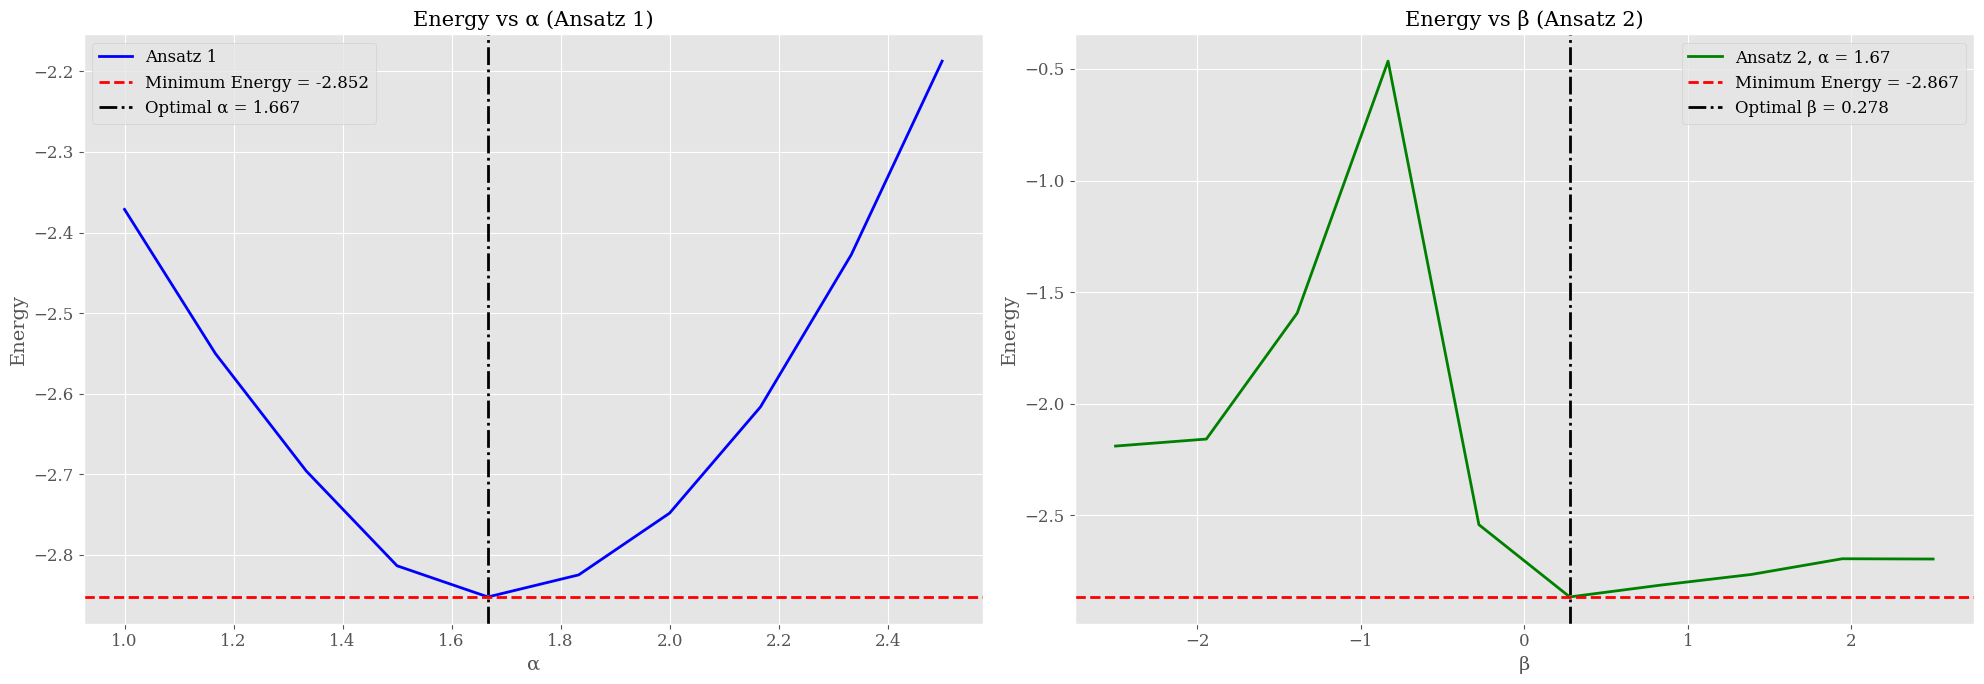

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.linewidth': 2,
})
plt.rcParams['text.usetex'] = False

fig, axs = plt.subplots(1, 2, figsize=(20, 7))

axs[0].plot(alpha_range, mean_energy_alpha, '-', label='Ansatz 1', color='blue')
axs[0].axhline(np.min(energies_alpha), color='red', linestyle='--',
               label=f'Minimum Energy = {np.min(energies_alpha):.3f}')
axs[0].axvline(optimal_alpha, linestyle='-.', color='black',
               label=f'Optimal α = {optimal_alpha:.3f}')
axs[0].set_xlabel('α')
axs[0].set_ylabel('Energy')
axs[0].set_title('Energy vs α (Ansatz 1)')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(beta_range, mean_energy_beta, label=f'Ansatz 2, α = {optimal_alpha:.2f}', color='green')
axs[1].axhline(np.min(energies_beta), color='red', linestyle='--',
               label=f'Minimum Energy = {np.min(energies_beta):.3f}')
axs[1].axvline(optimal_beta, linestyle='-.', color='black',
               label=f'Optimal β = {optimal_beta:.3f}')
axs[1].set_xlabel('β')
axs[1].set_ylabel('Energy')
axs[1].set_title('Energy vs β (Ansatz 2)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()

print(f"Minimum energy: {np.min(energies_alpha):.6f} (in atomic units) or {2*13.6*np.min(energies_alpha):.6f} (in eV)")

In [12]:
#for ansatz 3
beta_vals = np.linspace(0, 2, 10)
energy_ansatz3 = []
variance_ansatz3 = []

for b in tqdm(beta_vals, unit='beta', desc='Optimizing beta'):
    _, energies = lightatoms_VMC(pos_initial, Z, step, samples=1000000, alpha=optimal_alpha, beta=b, ansatz=3)
    mean_e = np.mean(energies)
    energy_ansatz3.append(mean_e)
    variance_ansatz3.append(np.var(energies))

optimal_beta_ansatz3 = beta_vals[np.argmin(energy_ansatz3)]
print(f"Optimal beta from Ansatz 3 (using alpha={optimal_alpha:.4f}): {optimal_beta_ansatz3:.4f}")

Optimizing beta: 100%|██████████| 10/10 [28:40<00:00, 172.08s/beta]

Optimal beta from Ansatz 3 (using alpha=1.6667): 0.4444


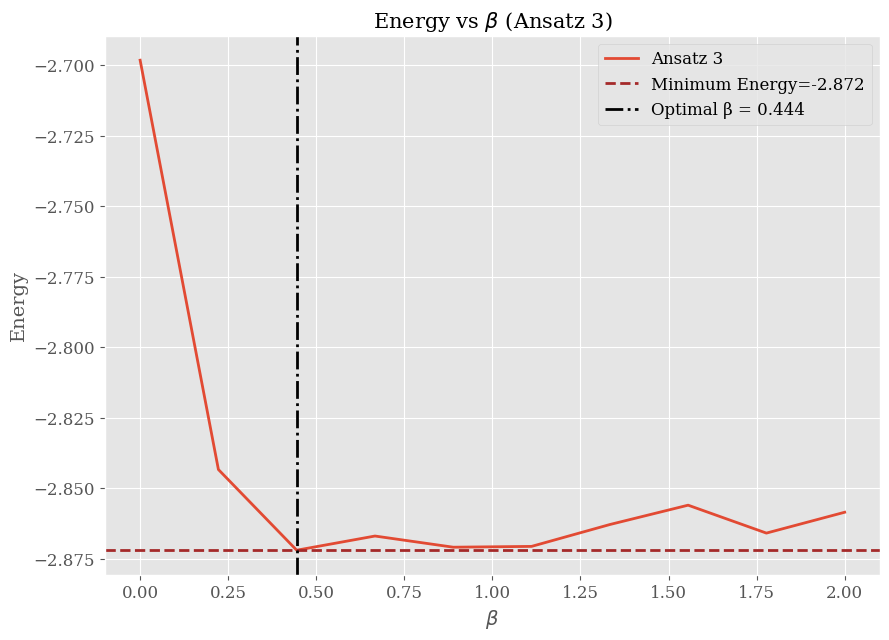

In [17]:
plt.figure(figsize=(10, 7))
plt.plot(beta_vals, energy_ansatz3, label='Ansatz 3')
plt.axhline(np.min(energy_ansatz3), color='brown', linestyle='--', label=f'Minimum Energy={np.min(energy_ansatz3):.3f}')
plt.axvline(optimal_beta_ansatz3, linestyle='-.', color='black', label=f'Optimal β = {optimal_beta_ansatz3:.3f}')
plt.xlabel(r'$\beta$')
plt.ylabel('Energy')
plt.title(r'Energy vs $\beta$ (Ansatz 3)')
plt.legend()
plt.grid(True)

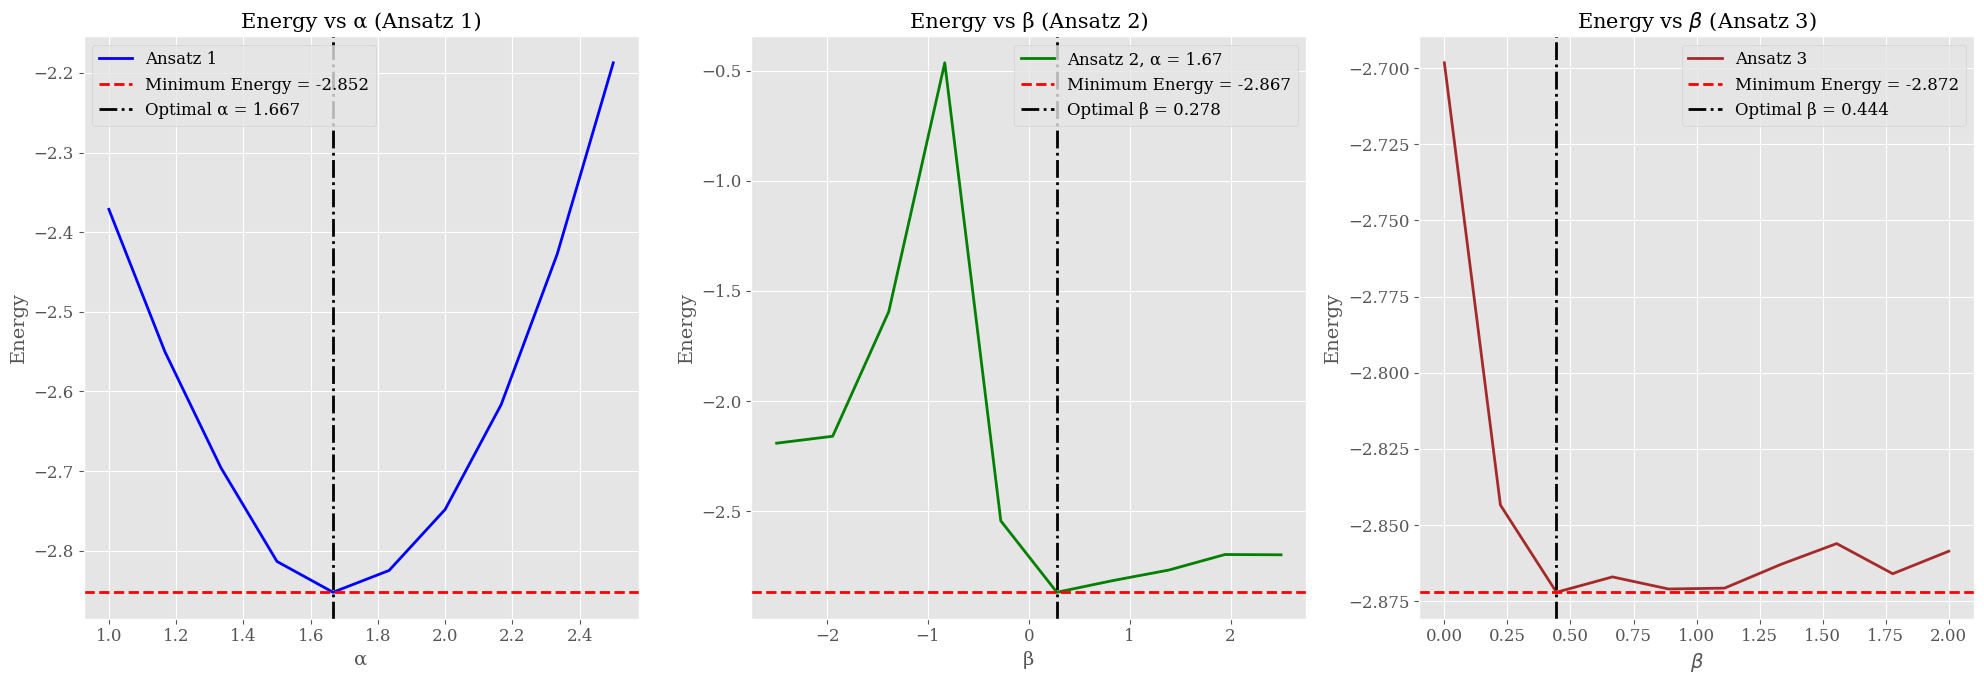

In [18]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.linewidth': 2,
})
plt.rcParams['text.usetex'] = False

fig, axs = plt.subplots(1,3, figsize=(20, 7))

axs[0].plot(alpha_range, mean_energy_alpha, '-', label='Ansatz 1', color='blue')
axs[0].axhline(np.min(energies_alpha), color='red', linestyle='--',
               label=f'Minimum Energy = {np.min(energies_alpha):.3f}')
axs[0].axvline(optimal_alpha, linestyle='-.', color='black',
               label=f'Optimal α = {optimal_alpha:.3f}')
axs[0].set_xlabel('α')
axs[0].set_ylabel('Energy')
axs[0].set_title('Energy vs α (Ansatz 1)')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(beta_range, mean_energy_beta, label=f'Ansatz 2, α = {optimal_alpha:.2f}', color='green')
axs[1].axhline(np.min(energies_beta), color='red', linestyle='--',
               label=f'Minimum Energy = {np.min(energies_beta):.3f}')
axs[1].axvline(optimal_beta, linestyle='-.', color='black',
               label=f'Optimal β = {optimal_beta:.3f}')
axs[1].set_xlabel('β')
axs[1].set_ylabel('Energy')
axs[1].set_title('Energy vs β (Ansatz 2)')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(beta_vals, energy_ansatz3, label='Ansatz 3', color='brown', linestyle='-')
axs[2].axhline(np.min(energy_ansatz3), color='red', linestyle='--', label=f'Minimum Energy = {np.min(energy_ansatz3):.3f}')
axs[2].axvline(optimal_beta_ansatz3, linestyle='-.', color='black', label=f'Optimal β = {optimal_beta_ansatz3:.3f}')
axs[2].set_xlabel(r'$\beta$')
axs[2].set_ylabel('Energy')
axs[2].set_title(r'Energy vs $\beta$ (Ansatz 3)')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()

In [15]:
np.save('energy_ansatz1.npy', mean_energy_alpha)
np.save('energy_ansatz2.npy', mean_energy_beta)
np.save('energy_ansatz3.npy', energy_ansatz3)
np.save('optimal_alpha.npy', optimal_alpha)
np.save('optimal_beta.npy', optimal_beta)
np.save('optimal_beta_ansatz3.npy', optimal_beta_ansatz3)

In [16]:
#2d plots for optimized alpha and beta for ansatz 2
alpha_values = np.linspace(optimal_alpha - 0.8, optimal_alpha + 0.8, 5)
beta_values = np.linspace(optimal_beta - 0.1, optimal_beta + 1, 5)
pos_initial = np.random.rand(2, 3)
energy_grid = np.zeros((len(alpha_values), len(beta_values)))
Z = 2
step = 0.15

for i, alpha in enumerate(tqdm(alpha_values, desc='Alpha', unit='alpha')):
    for j, beta in enumerate(beta_values):
        _, energies = lightatoms_VMC(pos_initial, 2, step, samples=100000, alpha=alpha, beta=beta, ansatz=2)
        energy_grid[i, j] = np.mean(energies)

Alpha: 100%|██████████| 5/5 [07:11<00:00, 86.37s/alpha]


In [19]:
min_idx = np.unravel_index(np.argmin(energy_grid), energy_grid.shape)
opt_alpha = alpha_values[min_idx[0]]
opt_beta = beta_values[min_idx[1]]
min_energy = energy_grid[min_idx]

print(f"Optimal parameters: α = {opt_alpha:.3f}, β = {opt_beta:.3f}")
print(f"Minimum energy: {min_energy:.6f} (in atomic units) or {2*13.6*min_energy:.6f} (in eV)")

Optimal parameters: α = 1.667, β = 0.453
Minimum energy: -2.885256 (in atomic units) or -78.478971 (in eV)


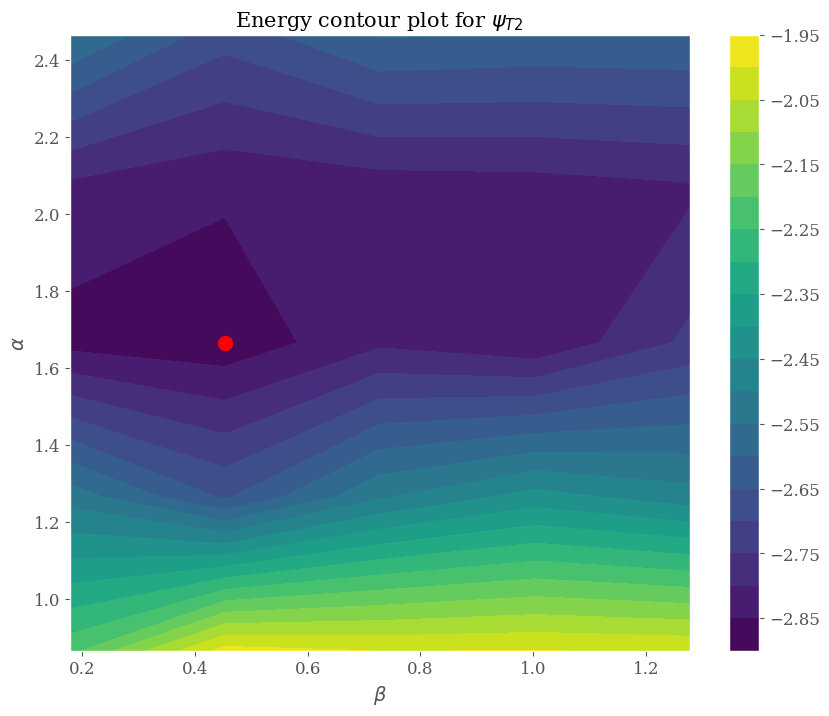

In [20]:
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('ggplot')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.linewidth': 2,
})
plt.rcParams['text.usetex'] = False

fig, ax = plt.subplots(figsize=(10, 8))
X, Y = np.meshgrid(beta_values, alpha_values)
contour = ax.contourf(X, Y, energy_grid, 20, cmap=cm.viridis)
fig.colorbar(contour, ax=ax)

ax.plot(opt_beta, opt_alpha, 'ro', markersize=10)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\alpha$')
ax.set_title('Energy contour plot for $\psi_{T2}$')
plt.show()


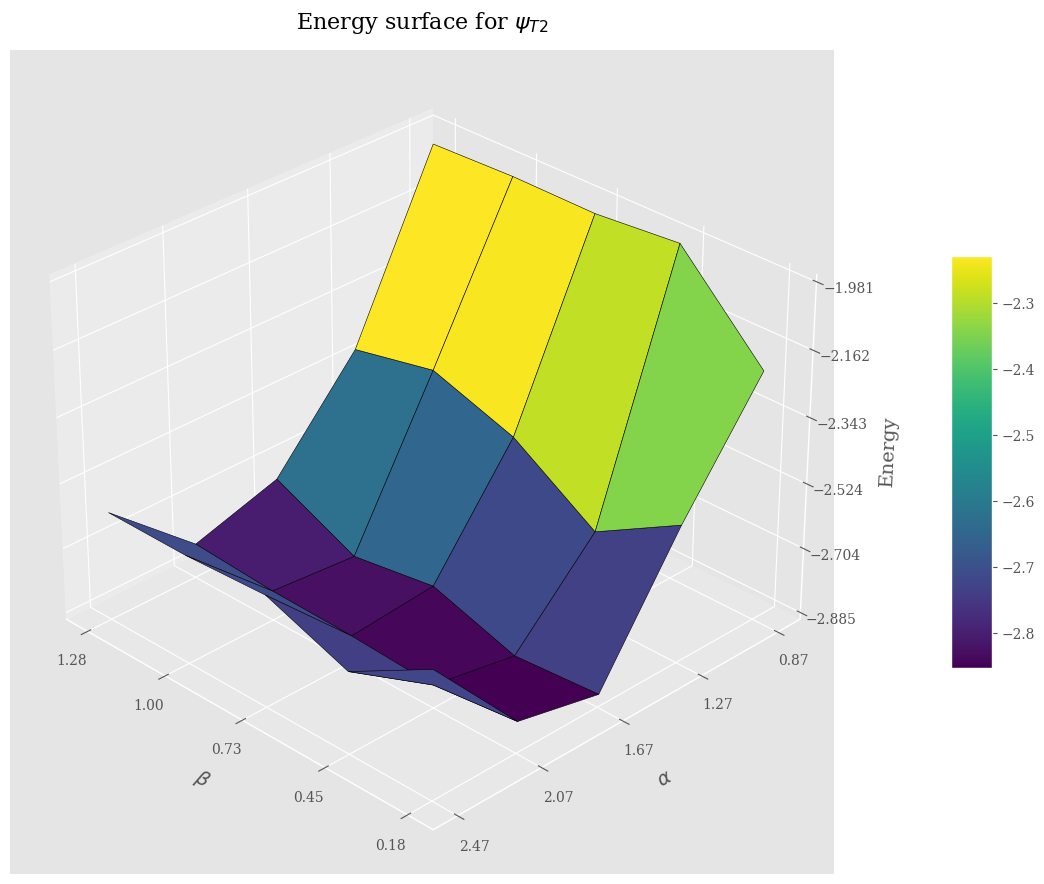

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

plt.style.use('ggplot')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 1.8,
})

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, energy_grid, cmap=cm.viridis, edgecolor='k', linewidth=0.4, antialiased=True)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

ax.set_xlabel(r'$\beta$', labelpad=12)
ax.set_ylabel(r'$\alpha$', labelpad=12)
ax.set_zlabel('Energy', labelpad=12)

ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=5)
ax.zaxis.set_tick_params(pad=5)

ax.set_xticks(np.round(np.linspace(X.min(), X.max(), 5), 2))
ax.set_yticks(np.round(np.linspace(Y.min(), Y.max(), 5), 2))
ax.set_zticks(np.round(np.linspace(energy_grid.min(), energy_grid.max(), 6), 3))

ax.view_init(elev=30, azim=135)

ax.set_title('Energy surface for $\\psi_{T2}$', pad=15)

plt.tight_layout()
plt.show()


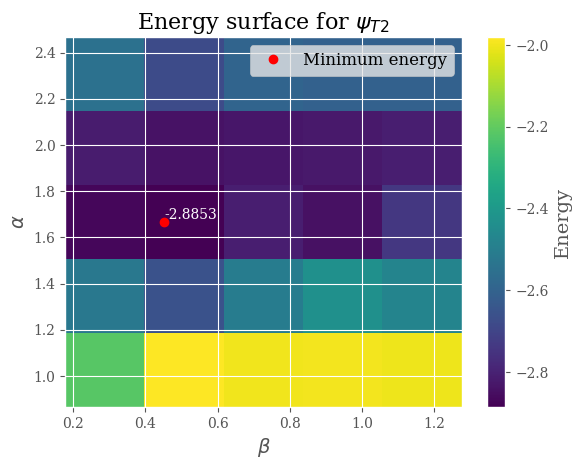

Minimum energy: -2.885256 a.u.
Optimal alpha: 1.666667
Optimal beta: 0.452778


In [22]:
import numpy as np
import matplotlib.pyplot as plt
min_index = np.unravel_index(np.argmin(energy_grid), energy_grid.shape)
min_alpha = alpha_values[min_index[0]]
min_beta = beta_values[min_index[1]]
min_energy = energy_grid[min_index]

plt.imshow(energy_grid, cmap='viridis',
           extent=[beta_values[0], beta_values[-1], alpha_values[0], alpha_values[-1]],
           origin='lower', aspect='auto')

plt.colorbar(label='Energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
plt.title('Energy surface for $\psi_{T2}$')
plt.plot(min_beta, min_alpha, 'ro', label='Minimum energy')
plt.text(min_beta, min_alpha,
         f'{min_energy:.4f}', color='white', fontsize=10, ha='left', va='bottom')

plt.legend()
plt.show()
print(f"Minimum energy: {min_energy:.6f} a.u.")
print(f"Optimal alpha: {min_alpha:.6f}")
print(f"Optimal beta: {min_beta:.6f}")


In [24]:
#2d plots for optimized alpha and beta for ansatz 3
alpha_values = np.linspace(optimal_alpha - 0.8, optimal_alpha + 0.5, 5)
beta_values = np.linspace(optimal_beta_ansatz3 - 0.4, optimal_beta_ansatz3 + 1, 5)

energy_grid_ansatz3 = np.zeros((len(alpha_values), len(beta_values)))

for i, alpha in enumerate(tqdm(alpha_values, desc='Alpha', unit='alpha')):
    for j, beta in enumerate(beta_values):
        _, energies = lightatoms_VMC(pos_initial, 2, step, samples=100000, alpha=alpha, beta=beta, ansatz=3)
        energy_grid_ansatz3[i, j] = np.mean(energies)

Alpha: 100%|██████████| 5/5 [07:10<00:00, 86.18s/alpha]


In [25]:
min_idx = np.unravel_index(np.argmin(energy_grid_ansatz3), energy_grid_ansatz3.shape)
opt_alpha_ansatz3 = alpha_values[min_idx[0]]
opt_beta_ansatz3 = beta_values[min_idx[1]]
min_energy_ansatz3 = energy_grid_ansatz3[min_idx]

print(f"Optimal parameters: α = {opt_alpha_ansatz3:.3f}, β = {opt_beta_ansatz3:.3f}")
print(f"Minimum energy: {min_energy_ansatz3:.6f} (in atomic units) or {2*13.6*min_energy_ansatz3:.6f} (in eV)")

Optimal parameters: α = 1.842, β = 0.744
Minimum energy: -2.909794 (in atomic units) or -79.146402 (in eV)


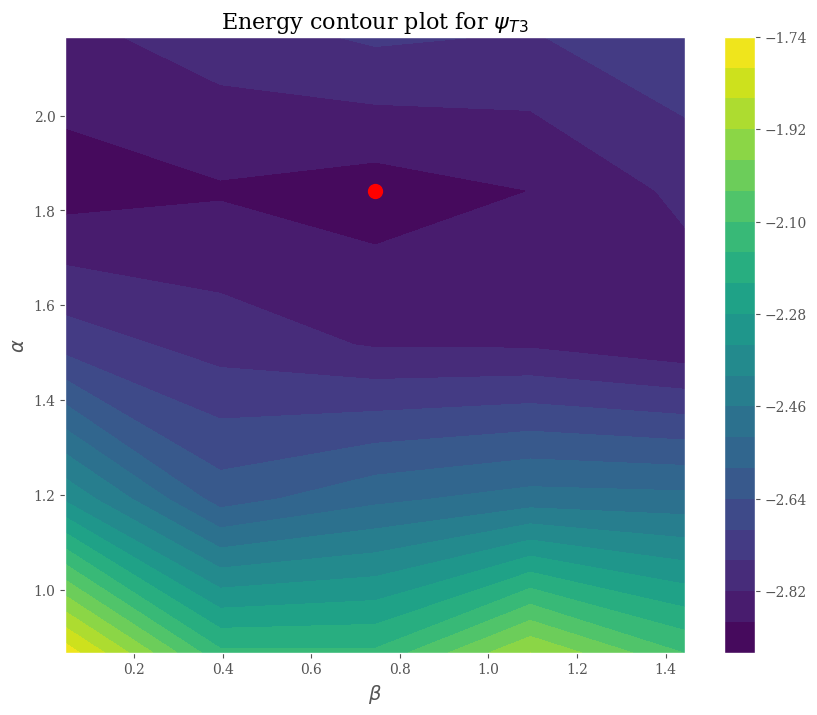

In [26]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, ax = plt.subplots(figsize=(10, 8))
X, Y = np.meshgrid(beta_values, alpha_values)
contour = ax.contourf(X, Y, energy_grid_ansatz3, 20, cmap=cm.viridis)
fig.colorbar(contour, ax=ax)

ax.plot(opt_beta_ansatz3, opt_alpha_ansatz3, 'ro', markersize=10)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\alpha$')
ax.set_title('Energy contour plot for $\psi_{T3}$')
plt.show()


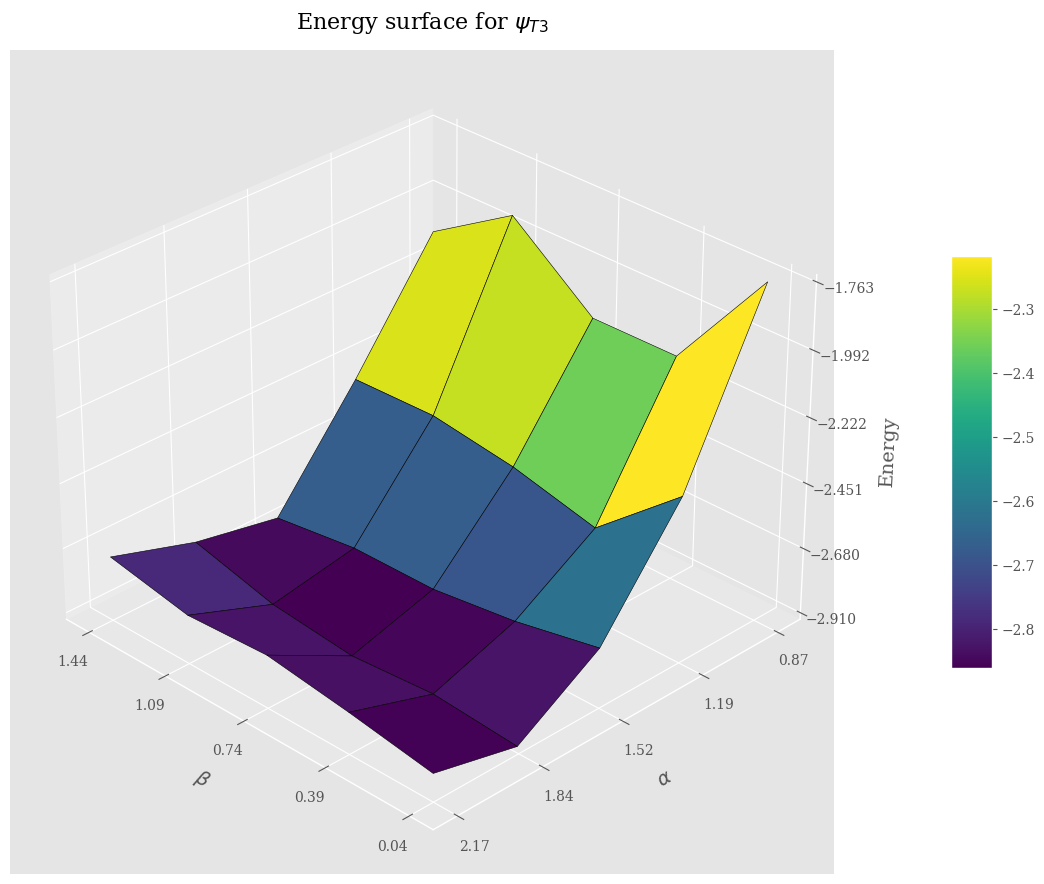

In [27]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, energy_grid_ansatz3, cmap=cm.viridis, edgecolor='k', linewidth=0.4, antialiased=True)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

ax.set_xlabel(r'$\beta$', labelpad=12)
ax.set_ylabel(r'$\alpha$', labelpad=12)
ax.set_zlabel('Energy', labelpad=12)

ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=5)
ax.zaxis.set_tick_params(pad=5)

ax.set_xticks(np.round(np.linspace(X.min(), X.max(), 5), 2))
ax.set_yticks(np.round(np.linspace(Y.min(), Y.max(), 5), 2))
ax.set_zticks(np.round(np.linspace(energy_grid_ansatz3.min(), energy_grid_ansatz3.max(), 6), 3))

ax.view_init(elev=30, azim=135)

ax.set_title('Energy surface for $\\psi_{T3}$', pad=15)

plt.tight_layout()
plt.show()

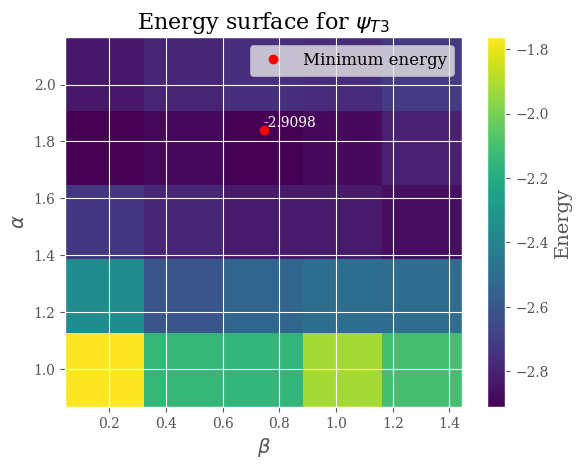

In [28]:
import numpy as np
import matplotlib.pyplot as plt

min_index = np.unravel_index(np.argmin(energy_grid_ansatz3), energy_grid_ansatz3.shape)
min_alpha = alpha_values[min_index[0]]
min_beta = beta_values[min_index[1]]
min_energy = energy_grid_ansatz3[min_index]

plt.imshow(energy_grid_ansatz3, cmap='viridis',
           extent=[beta_values[0], beta_values[-1], alpha_values[0], alpha_values[-1]],
           origin='lower', aspect='auto')

plt.colorbar(label='Energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
plt.title(r'Energy surface for $\psi_{T3}$')

plt.plot(min_beta, min_alpha, 'ro', label='Minimum energy')
plt.text(min_beta, min_alpha,
         f'{min_energy:.4f}', color='white', fontsize=10, ha='left', va='bottom')

plt.legend()
plt.show()


In [29]:
print(f"Minimum energy: {min_energy:.6f} a.u.")
print(f"Optimal alpha: {min_alpha:.6f}")
print(f"Optimal beta: {min_beta:.6f}")

Minimum energy: -2.909794 a.u.
Optimal alpha: 1.841667
Optimal beta: 0.744444


| Parameter    | Ansatz 1      | Ansatz 2      | Ansatz 3      |
| ------------ | ------------- | ------------- | ------------- |
| $\alpha$     | 1.6667       | 1.666667      |1.841667 |
| $\beta$      | —             | 0.452778 |0.744444 |
| $E_0$ (a.u.) | -2.852257 | -2.885256 a.u. | -2.909794 a.u.|


In [33]:
alpha = 1.6667 # replace with actual value
beta = 0   # replace with actual value
ansatz = 1

In [34]:
pos_initial = np.random.rand(2, 3)
position_saved_1, _ = lightatoms_VMC(pos_initial, Z=2, step=0.15, samples=100000, alpha=alpha, beta=beta, ansatz=ansatz)

In [35]:
import numpy as np

r12_values = [np.linalg.norm(p[0] - p[1]) for p in position_saved_1]
mean_r12 = np.mean(r12_values)
print(f"Mean inter-electronic distance <r12> = {mean_r12:.5f} a.u.")

Mean inter-electronic distance <r12> = 1.28127 a.u.


In [36]:
alpha = 1.6667 # replace with actual value
beta = 0.452778   # replace with actual value
ansatz = 2

In [37]:
pos_initial = np.random.rand(2, 3)
position_saved_2, _ = lightatoms_VMC(pos_initial, Z=2, step=0.15, samples=100000, alpha=alpha, beta=beta, ansatz=ansatz)

In [38]:
import numpy as np

r12_values = [np.linalg.norm(p[0] - p[1]) for p in position_saved_2]
mean_r12 = np.mean(r12_values)
print(f"Mean inter-electronic distance <r12> = {mean_r12:.5f} a.u.")

Mean inter-electronic distance <r12> = 1.73514 a.u.


In [39]:
alpha = 1.84167 # replace with actual value
beta = 0.744   # replace with actual value
ansatz = 3

In [40]:
pos_initial = np.random.rand(2, 3)
position_saved_3, _ = lightatoms_VMC(pos_initial, Z=2, step=0.15, samples=100000, alpha=alpha, beta=beta, ansatz=ansatz)

In [41]:
import numpy as np

r12_values = [np.linalg.norm(p[0] - p[1]) for p in position_saved_3]
mean_r12 = np.mean(r12_values)
print(f"Mean inter-electronic distance <r12> = {mean_r12:.5f} a.u.")

Mean inter-electronic distance <r12> = 1.32196 a.u.


# **Theoretical Values:**
Therefore, ansatz 3 turned out to be a better wavefunction for the description of Helium atom.

| Ion  | $Z$ | $E_0$ (a.u.) | $\langle r_{12} \rangle$ (a.u., approx) |
| ---- | --- | ------------ | --------------------------------------- |
| He   | 2   | −2.90372     | \~1.40                                |
| Li²⁺ | 3   | −7.27991     | \~0.97                                 |
| Be³⁺ | 4   | −13.65557    | \~0.75                                  |


# **For  Lithium ion:**

In [42]:
alpha_range = np.linspace(1.0, 5, 10)
pos_initial = np.random.rand(2, 3)
Z = 3
step = 0.15

print("Optimizing alpha using Ansatz 1...")
energies_alpha, optimal_alpha, variance_alpha, mean_energy_alpha = lightatoms_alpha_opt(
    alpha_range, pos_initial, Z, step=step, samples=1000000, ansatz=1)

print(f"Optimal alpha from Ansatz 1: {optimal_alpha:.4f}")

Optimizing alpha using Ansatz 1...


Optimizing alpha: 100%|██████████| 10/10 [17:00<00:00, 102.09s/alpha]


Optimal alpha from Ansatz 1: 2.7778


In [43]:
beta_range = np.linspace(-5, 5, 10)

print("Optimizing beta using Ansatz 2 with fixed alpha...")
energies_beta, optimal_beta, variance_beta, mean_energy_beta = lightatoms_beta_opt(
    beta_range, optimal_alpha, pos_initial, Z, step=step, samples=1000000, ansatz=2)

print(f"Optimal beta from Ansatz 2 (using alpha={optimal_alpha:.4f}): {optimal_beta:.4f}")

Optimizing beta using Ansatz 2 with fixed alpha...


Optimizing beta: 100%|██████████| 10/10 [28:39<00:00, 171.90s/beta]


Optimal beta from Ansatz 2 (using alpha=2.7778): 0.5556


Minimum energy: -7.209534 (in atomic units) or -294.148981 (in eV)


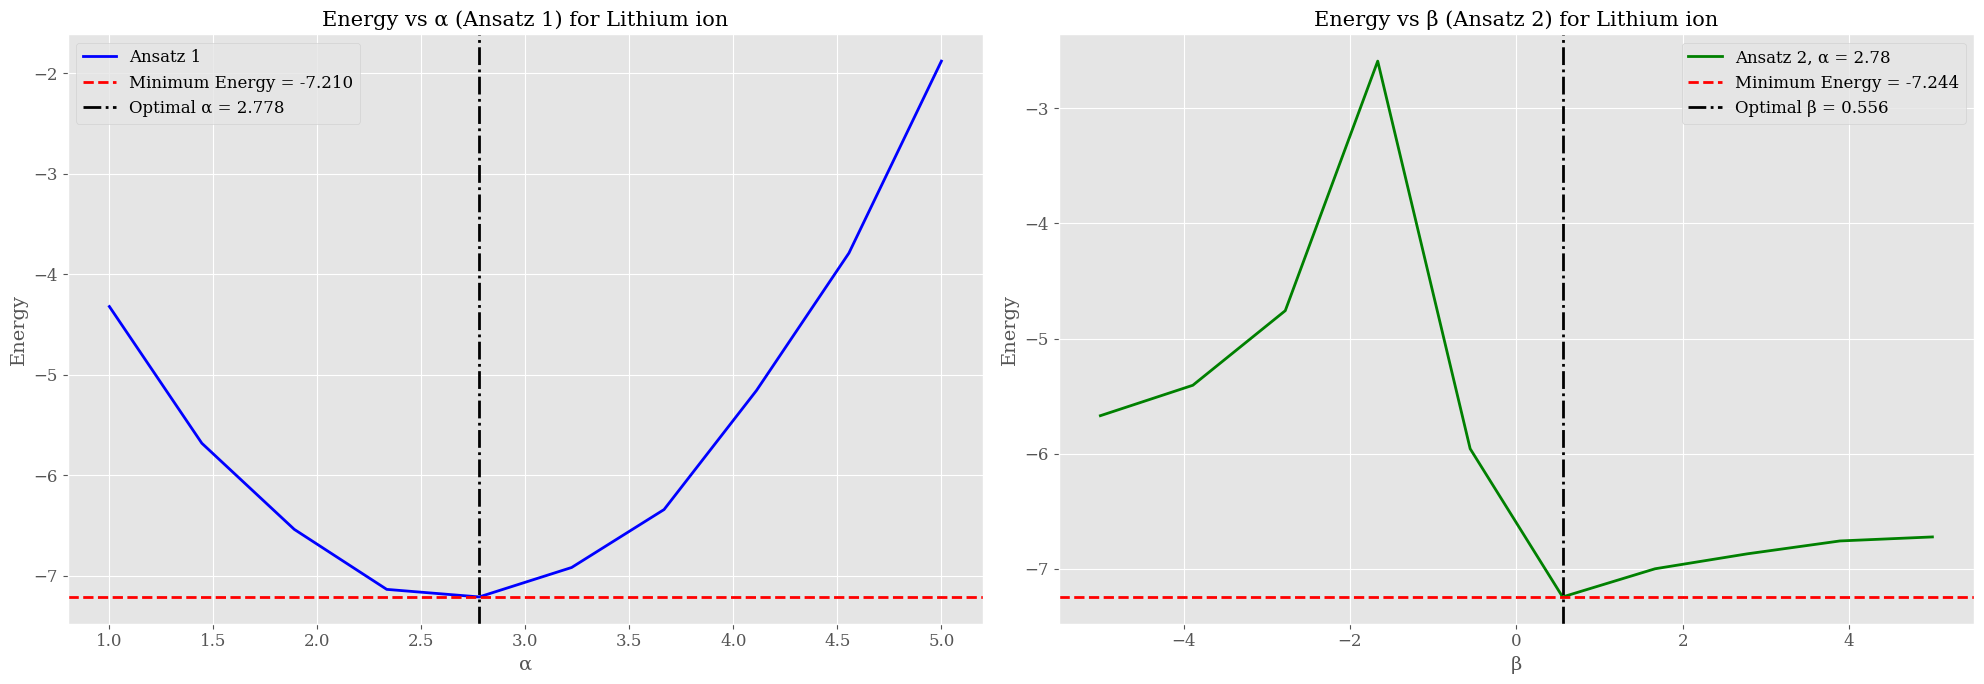

In [44]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.linewidth': 2,
})
plt.rcParams['text.usetex'] = False

fig, axs = plt.subplots(1, 2, figsize=(20, 7))

axs[0].plot(alpha_range, mean_energy_alpha, '-', label='Ansatz 1', color='blue')
axs[0].axhline(np.min(energies_alpha), color='red', linestyle='--',
               label=f'Minimum Energy = {np.min(energies_alpha):.3f}')
axs[0].axvline(optimal_alpha, linestyle='-.', color='black',
               label=f'Optimal α = {optimal_alpha:.3f}')
axs[0].set_xlabel('α')
axs[0].set_ylabel('Energy')
axs[0].set_title('Energy vs α (Ansatz 1) for Lithium ion')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(beta_range, mean_energy_beta, label=f'Ansatz 2, α = {optimal_alpha:.2f}', color='green')
axs[1].axhline(np.min(energies_beta), color='red', linestyle='--',
               label=f'Minimum Energy = {np.min(energies_beta):.3f}')
axs[1].axvline(optimal_beta, linestyle='-.', color='black',
               label=f'Optimal β = {optimal_beta:.3f}')
axs[1].set_xlabel('β')
axs[1].set_ylabel('Energy')
axs[1].set_title('Energy vs β (Ansatz 2) for Lithium ion')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()

print(f"Minimum energy: {np.min(energies_alpha):.6f} (in atomic units) or {3*13.6*np.min(energies_alpha):.6f} (in eV)")

In [52]:
#for ansatz 3
beta_vals = np.linspace(0.1, 3, 10)
energy_ansatz3 = []
variance_ansatz3 = []

for b in tqdm(beta_vals, unit='beta', desc='Optimizing beta'):
    _, energies = lightatoms_VMC(pos_initial, Z, step, samples=1000000, alpha=optimal_alpha, beta=b, ansatz=3)
    mean_e = np.mean(energies)
    energy_ansatz3.append(mean_e)
    variance_ansatz3.append(np.var(energies))

optimal_beta_ansatz3 = beta_vals[np.argmin(energy_ansatz3)]
print(f"Optimal beta from Ansatz 3 (using alpha={optimal_alpha:.4f}): {optimal_beta_ansatz3:.4f}")

Optimizing beta: 100%|██████████| 10/10 [28:39<00:00, 171.92s/beta]

Optimal beta from Ansatz 3 (using alpha=2.7778): 0.7444


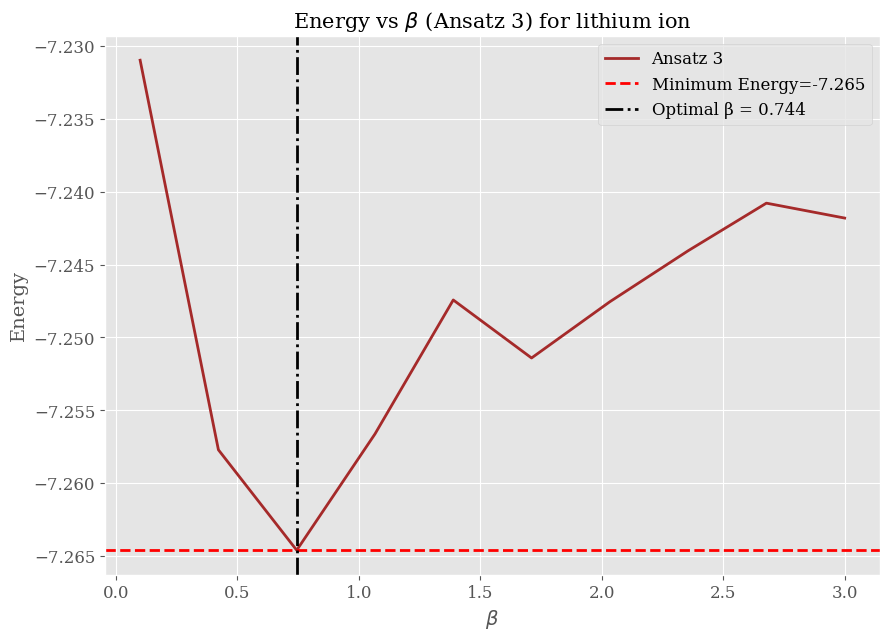

In [56]:
plt.figure(figsize=(10, 7))
plt.plot(beta_vals, energy_ansatz3, label='Ansatz 3', color='brown')
plt.axhline(np.min(energy_ansatz3), color='red', linestyle='--', label=f'Minimum Energy={np.min(energy_ansatz3):.3f}')
plt.axvline(optimal_beta_ansatz3, linestyle='-.', color='black', label=f'Optimal β = {optimal_beta_ansatz3:.3f}')
plt.xlabel(r'$\beta$')
plt.ylabel('Energy')
plt.title(r'Energy vs $\beta$ (Ansatz 3) for lithium ion')
plt.legend()
plt.grid(True)

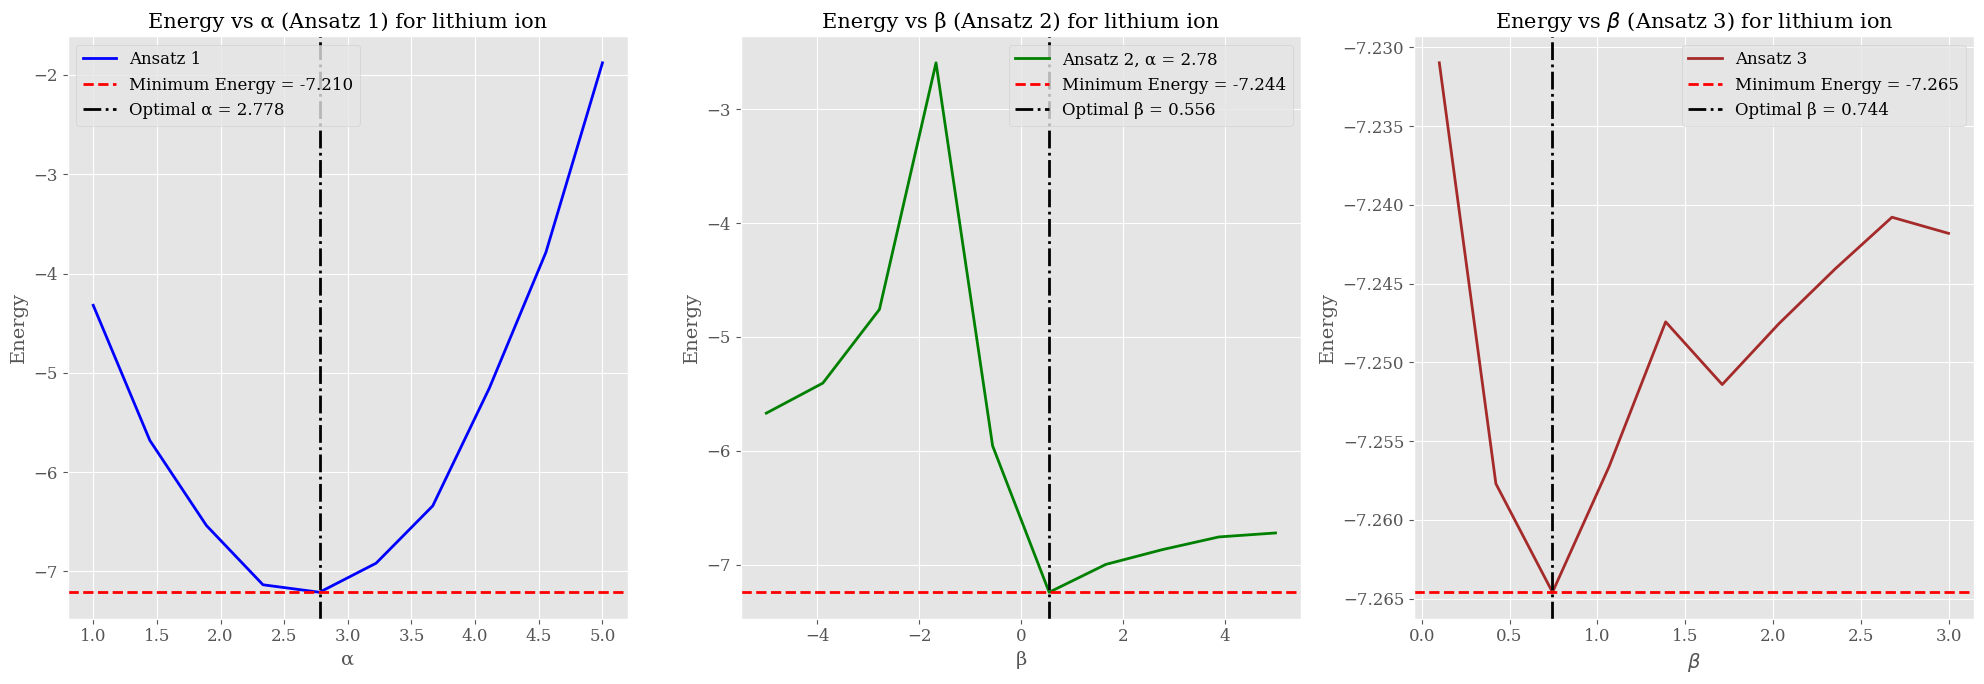

In [55]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.linewidth': 2,
})
plt.rcParams['text.usetex'] = False

fig, axs = plt.subplots(1,3, figsize=(20, 7))

axs[0].plot(alpha_range, mean_energy_alpha, '-', label='Ansatz 1', color='blue')
axs[0].axhline(np.min(energies_alpha), color='red', linestyle='--',
               label=f'Minimum Energy = {np.min(energies_alpha):.3f}')
axs[0].axvline(optimal_alpha, linestyle='-.', color='black',
               label=f'Optimal α = {optimal_alpha:.3f}')
axs[0].set_xlabel('α')
axs[0].set_ylabel('Energy')
axs[0].set_title('Energy vs α (Ansatz 1) for lithium ion')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(beta_range, mean_energy_beta, label=f'Ansatz 2, α = {optimal_alpha:.2f}', color='green')
axs[1].axhline(np.min(energies_beta), color='red', linestyle='--',
               label=f'Minimum Energy = {np.min(energies_beta):.3f}')
axs[1].axvline(optimal_beta, linestyle='-.', color='black',
               label=f'Optimal β = {optimal_beta:.3f}')
axs[1].set_xlabel('β')
axs[1].set_ylabel('Energy')
axs[1].set_title('Energy vs β (Ansatz 2) for lithium ion')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(beta_vals, energy_ansatz3, label='Ansatz 3', color='brown', linestyle='-')
axs[2].axhline(np.min(energy_ansatz3), color='red', linestyle='--', label=f'Minimum Energy = {np.min(energy_ansatz3):.3f}')
axs[2].axvline(optimal_beta_ansatz3, linestyle='-.', color='black', label=f'Optimal β = {optimal_beta_ansatz3:.3f}')
axs[2].set_xlabel(r'$\beta$')
axs[2].set_ylabel('Energy')
axs[2].set_title(r'Energy vs $\beta$ (Ansatz 3) for lithium ion')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()

In [62]:
#2d plots for optimized alpha and beta for ansatz 2
alpha_values = np.linspace(optimal_alpha - 1, optimal_alpha + 1, 5)
beta_values = np.linspace(optimal_beta - 0.3, optimal_beta + 2, 7)
pos_initial = np.random.rand(2, 3)
energy_grid = np.zeros((len(alpha_values), len(beta_values)))
Z = 3
step = 0.15

for i, alpha in enumerate(tqdm(alpha_values, desc='Alpha', unit='alpha')):
    for j, beta in enumerate(beta_values):
        _, energies = lightatoms_VMC(pos_initial, 3, step, samples=10000, alpha=alpha, beta=beta, ansatz=2)
        energy_grid[i, j] = np.mean(energies)


Alpha: 100%|██████████| 5/5 [01:03<00:00, 12.69s/alpha]


In [63]:
min_idx = np.unravel_index(np.argmin(energy_grid), energy_grid.shape)
opt_alpha = alpha_values[min_idx[0]]
opt_beta = beta_values[min_idx[1]]
min_energy = energy_grid[min_idx]

print(f"Optimal parameters: α = {opt_alpha:.3f}, β = {opt_beta:.3f}")
print(f"Minimum energy: {min_energy:.6f} (in atomic units) or {3*13.6*min_energy:.6f} (in eV)")

Optimal parameters: α = 3.278, β = 1.789
Minimum energy: -7.405067 (in atomic units) or -302.126743 (in eV)


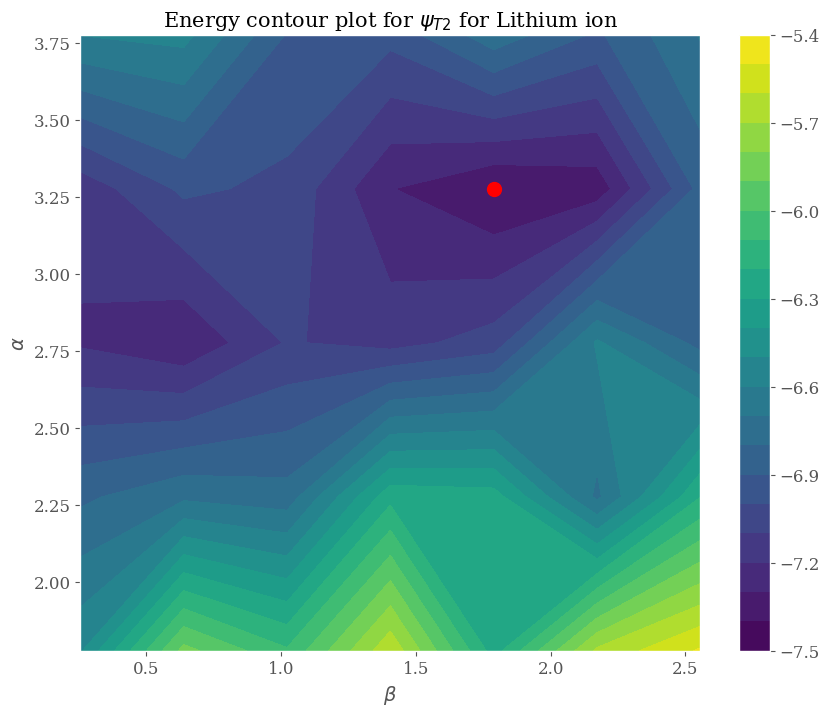

In [64]:
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('ggplot')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.linewidth': 2,
})
plt.rcParams['text.usetex'] = False
fig, ax = plt.subplots(figsize=(10, 8))
X, Y = np.meshgrid(beta_values, alpha_values)
contour = ax.contourf(X, Y, energy_grid, 20, cmap=cm.viridis)
fig.colorbar(contour, ax=ax)

ax.plot(opt_beta, opt_alpha, 'ro', markersize=10)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\alpha$')
ax.set_title('Energy contour plot for $\psi_{T2}$ for Lithium ion')
plt.show()


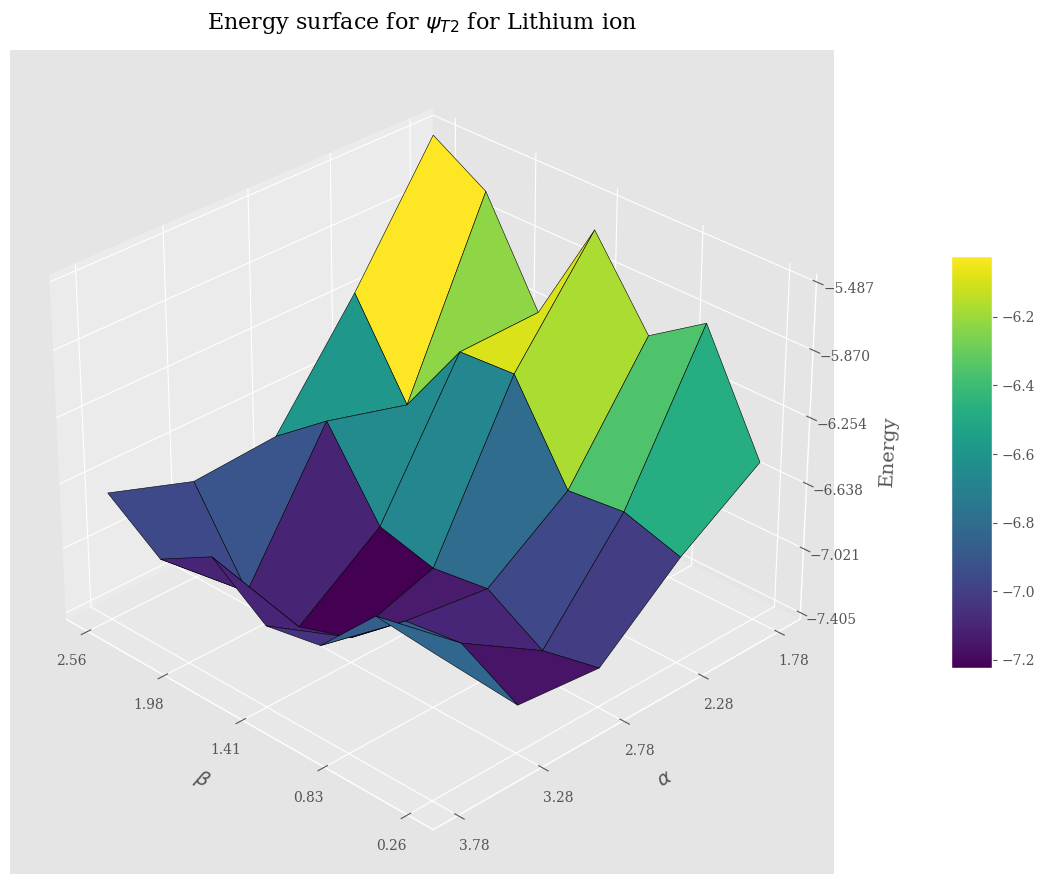

In [65]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

plt.style.use('ggplot')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 1.8,
})

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, energy_grid, cmap=cm.viridis, edgecolor='k', linewidth=0.4, antialiased=True)


fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

ax.set_xlabel(r'$\beta$', labelpad=12)
ax.set_ylabel(r'$\alpha$', labelpad=12)
ax.set_zlabel('Energy', labelpad=12)

ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=5)
ax.zaxis.set_tick_params(pad=5)

ax.set_xticks(np.round(np.linspace(X.min(), X.max(), 5), 2))
ax.set_yticks(np.round(np.linspace(Y.min(), Y.max(), 5), 2))
ax.set_zticks(np.round(np.linspace(energy_grid.min(), energy_grid.max(), 6), 3))

ax.view_init(elev=30, azim=135)

ax.set_title('Energy surface for $\\psi_{T2}$ for Lithium ion', pad=15)

plt.tight_layout()
plt.show()


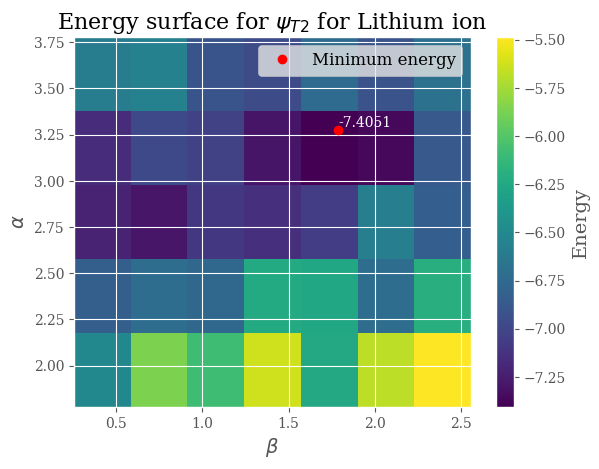

Minimum energy: -7.405067 a.u.
Optimal alpha: 3.277778
Optimal beta: 1.788889


In [66]:
import numpy as np
import matplotlib.pyplot as plt

min_index = np.unravel_index(np.argmin(energy_grid), energy_grid.shape)
min_alpha = alpha_values[min_index[0]]
min_beta = beta_values[min_index[1]]
min_energy = energy_grid[min_index]

plt.imshow(energy_grid, cmap='viridis',
           extent=[beta_values[0], beta_values[-1], alpha_values[0], alpha_values[-1]],
           origin='lower', aspect='auto')

plt.colorbar(label='Energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
plt.title('Energy surface for $\psi_{T2}$ for Lithium ion')

plt.plot(min_beta, min_alpha, 'ro', label='Minimum energy')
plt.text(min_beta, min_alpha,
         f'{min_energy:.4f}', color='white', fontsize=10, ha='left', va='bottom')

plt.legend()
plt.show()

print(f"Minimum energy: {min_energy:.6f} a.u.")
print(f"Optimal alpha: {min_alpha:.6f}")
print(f"Optimal beta: {min_beta:.6f}")


In [67]:
#2d plots for optimized alpha and beta for ansatz 3
alpha_values = np.linspace(optimal_alpha - 1, optimal_alpha + 1, 5)
beta_values = np.linspace(optimal_beta_ansatz3 - 0.6, optimal_beta_ansatz3 + 1, 5)

energy_grid_ansatz3 = np.zeros((len(alpha_values), len(beta_values)))

for i, alpha in enumerate(tqdm(alpha_values, desc='Alpha', unit='alpha')):
    for j, beta in enumerate(beta_values):
        _, energies = lightatoms_VMC(pos_initial, 3, step, samples=10000, alpha=alpha, beta=beta, ansatz=3)
        energy_grid_ansatz3[i, j] = np.mean(energies)

Alpha: 100%|██████████| 5/5 [00:45<00:00,  9.03s/alpha]


In [68]:
min_idx = np.unravel_index(np.argmin(energy_grid_ansatz3), energy_grid_ansatz3.shape)
opt_alpha_ansatz3 = alpha_values[min_idx[0]]
opt_beta_ansatz3 = beta_values[min_idx[1]]
min_energy_ansatz3 = energy_grid_ansatz3[min_idx]

print(f"Optimal parameters: α = {opt_alpha_ansatz3:.3f}, β = {opt_beta_ansatz3:.3f}")
print(f"Minimum energy: {min_energy_ansatz3:.6f} (in atomic units) or {3*13.6*min_energy_ansatz3:.6f} (in eV)")

Optimal parameters: α = 2.778, β = 0.944
Minimum energy: -7.303517 (in atomic units) or -297.983504 (in eV)


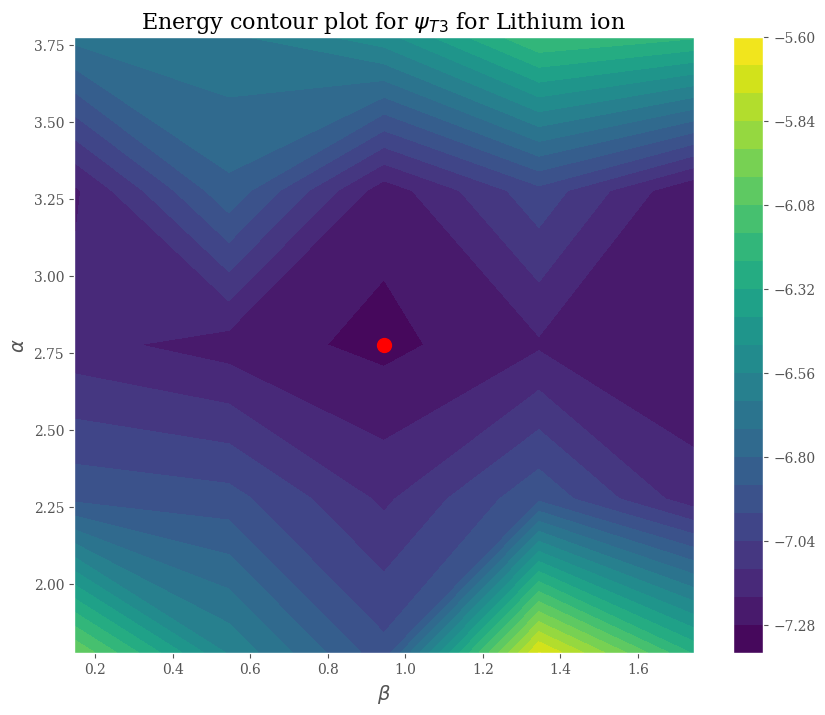

In [69]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, ax = plt.subplots(figsize=(10, 8))
X, Y = np.meshgrid(beta_values, alpha_values)
contour = ax.contourf(X, Y, energy_grid_ansatz3, 20, cmap=cm.viridis)
fig.colorbar(contour, ax=ax)

ax.plot(opt_beta_ansatz3, opt_alpha_ansatz3, 'ro', markersize=10)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\alpha$')
ax.set_title('Energy contour plot for $\psi_{T3}$ for Lithium ion')
plt.show()


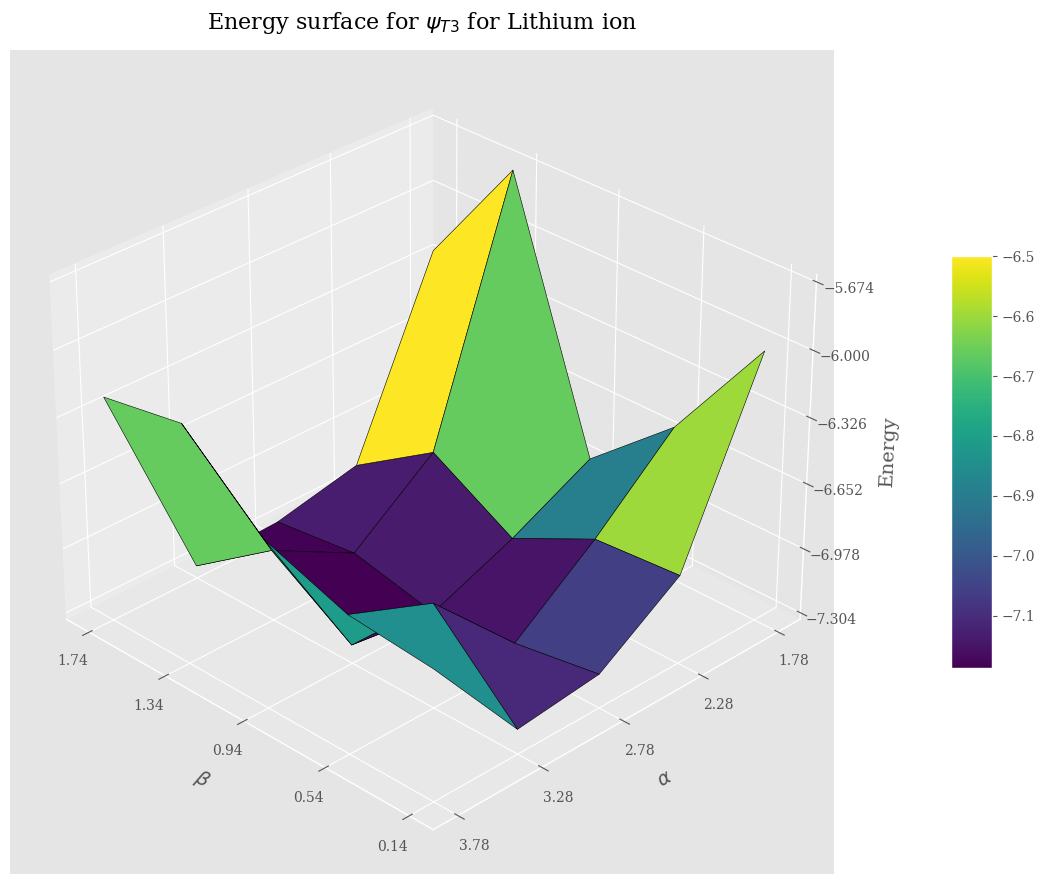

In [71]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, energy_grid_ansatz3, cmap=cm.viridis, edgecolor='k', linewidth=0.4, antialiased=True)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

ax.set_xlabel(r'$\beta$', labelpad=12)
ax.set_ylabel(r'$\alpha$', labelpad=12)
ax.set_zlabel('Energy', labelpad=12)

ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=5)
ax.zaxis.set_tick_params(pad=5)

ax.set_xticks(np.round(np.linspace(X.min(), X.max(), 5), 2))
ax.set_yticks(np.round(np.linspace(Y.min(), Y.max(), 5), 2))
ax.set_zticks(np.round(np.linspace(energy_grid_ansatz3.min(), energy_grid_ansatz3.max(), 6), 3))

ax.view_init(elev=30, azim=135)


ax.set_title('Energy surface for $\\psi_{T3}$ for Lithium ion', pad=15)

plt.tight_layout()
plt.show()

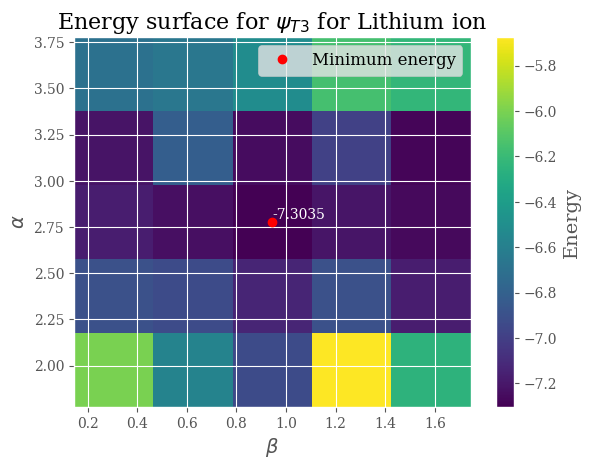

In [72]:
import numpy as np
import matplotlib.pyplot as plt


min_index = np.unravel_index(np.argmin(energy_grid_ansatz3), energy_grid_ansatz3.shape)
min_alpha = alpha_values[min_index[0]]
min_beta = beta_values[min_index[1]]
min_energy = energy_grid_ansatz3[min_index]

plt.imshow(energy_grid_ansatz3, cmap='viridis',
           extent=[beta_values[0], beta_values[-1], alpha_values[0], alpha_values[-1]],
           origin='lower', aspect='auto')

plt.colorbar(label='Energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
plt.title(r'Energy surface for $\psi_{T3}$ for Lithium ion')

plt.plot(min_beta, min_alpha, 'ro', label='Minimum energy')
plt.text(min_beta, min_alpha,
         f'{min_energy:.4f}', color='white', fontsize=10, ha='left', va='bottom')

plt.legend()
plt.show()


In [124]:
print(f"Minimum energy: {min_energy:.6f} a.u.")
print(f"Optimal alpha: {min_alpha:.6f}")
print(f"Optimal beta: {min_beta:.6f}")

Minimum energy: -7.308978 a.u.
Optimal alpha: 2.777778
Optimal beta: 0.913889


# **Theoretical Values:**
Therefore, ansatz 3 turned out to be a better wavefunction for the description of Lithium atom as well.

| Ion  | $Z$ | $E_0$ (a.u.) | $\langle r_{12} \rangle$ (a.u., approx) |
| ---- | --- | ------------ | --------------------------------------- |
| He   | 2   | −2.90372     | \~1.40                                |
| Li²⁺ | 3   | −7.27991     | \~0.97                                 |
| Be³⁺ | 4   | −13.65557    | \~0.75                                  |


# Experimental values:

| Parameter    | Ansatz 1      | Ansatz 2      | Ansatz 3      |
| ------------ | ------------- | ------------- | ------------- |
| $\alpha$     | 2.7778       | 3.278     |2.777778 |
| $\beta$      | —             | 1.789|0.913889 |
| $E_0$ (a.u.) | -7.210 a.u. | -7.405067 a.u. | -7.308978 a.u.|


In [73]:
alpha = 2.7778
beta = 0
ansatz = 1

In [74]:
pos_initial = np.random.rand(2, 3)
position_saved_1, _ = lightatoms_VMC(pos_initial, Z=3, step=0.15, samples=100000, alpha=alpha, beta=beta, ansatz=ansatz)

In [75]:
import numpy as np

r12_values = [np.linalg.norm(p[0] - p[1]) for p in position_saved_1]
mean_r12 = np.mean(r12_values)
print(f"Mean inter-electronic distance <r12> = {mean_r12:.5f} a.u.")

Mean inter-electronic distance <r12> = 0.81350 a.u.


In [76]:
alpha = 3.278
beta = 1.789
ansatz = 2

In [77]:
pos_initial = np.random.rand(2, 3)
position_saved_2, _ = lightatoms_VMC(pos_initial, Z=3, step=0.15, samples=100000, alpha=alpha, beta=beta, ansatz=ansatz)

In [78]:
import numpy as np

r12_values = [np.linalg.norm(p[0] - p[1]) for p in position_saved_2]
mean_r12 = np.mean(r12_values)
print(f"Mean inter-electronic distance <r12> = {mean_r12:.5f} a.u.")

Mean inter-electronic distance <r12> = 0.84833 a.u.


In [79]:
alpha = 2.777778
beta = 0.913889
ansatz = 3

In [80]:
pos_initial = np.random.rand(2, 3)
position_saved_3, _ = lightatoms_VMC(pos_initial, Z=3, step=0.15, samples=100000, alpha=alpha, beta=beta, ansatz=ansatz)

In [81]:
import numpy as np

r12_values = [np.linalg.norm(p[0] - p[1]) for p in position_saved_3]
mean_r12 = np.mean(r12_values)
print(f"Mean inter-electronic distance <r12> = {mean_r12:.5f} a.u.")

Mean inter-electronic distance <r12> = 0.83736 a.u.


# For Beryllium:

In [82]:
alpha_range = np.linspace(1.0, 5, 10)
pos_initial = np.random.rand(2, 3)
Z = 4
step = 0.15

print("Optimizing alpha using Ansatz 1...")
energies_alpha, optimal_alpha, variance_alpha, mean_energy_alpha = lightatoms_alpha_opt(
    alpha_range, pos_initial, Z, step=step, samples=1000000, ansatz=1)

print(f"Optimal alpha from Ansatz 1: {optimal_alpha:.4f}")

Optimizing alpha using Ansatz 1...


Optimizing alpha: 100%|██████████| 10/10 [16:53<00:00, 101.37s/alpha]


Optimal alpha from Ansatz 1: 3.6667


In [83]:
beta_range = np.linspace(-5, 5, 10)

print("Optimizing beta using Ansatz 2 with fixed alpha...")
energies_beta, optimal_beta, variance_beta, mean_energy_beta = lightatoms_beta_opt(
    beta_range, optimal_alpha, pos_initial, Z, step=step, samples=1000000, ansatz=2)

print(f"Optimal beta from Ansatz 2 (using alpha={optimal_alpha:.4f}): {optimal_beta:.4f}")

Optimizing beta using Ansatz 2 with fixed alpha...


Optimizing beta: 100%|██████████| 10/10 [29:32<00:00, 177.27s/beta]


Optimal beta from Ansatz 2 (using alpha=3.6667): 0.5556


Minimum energy: -13.590483 (in atomic units) or -739.322256 (in eV)


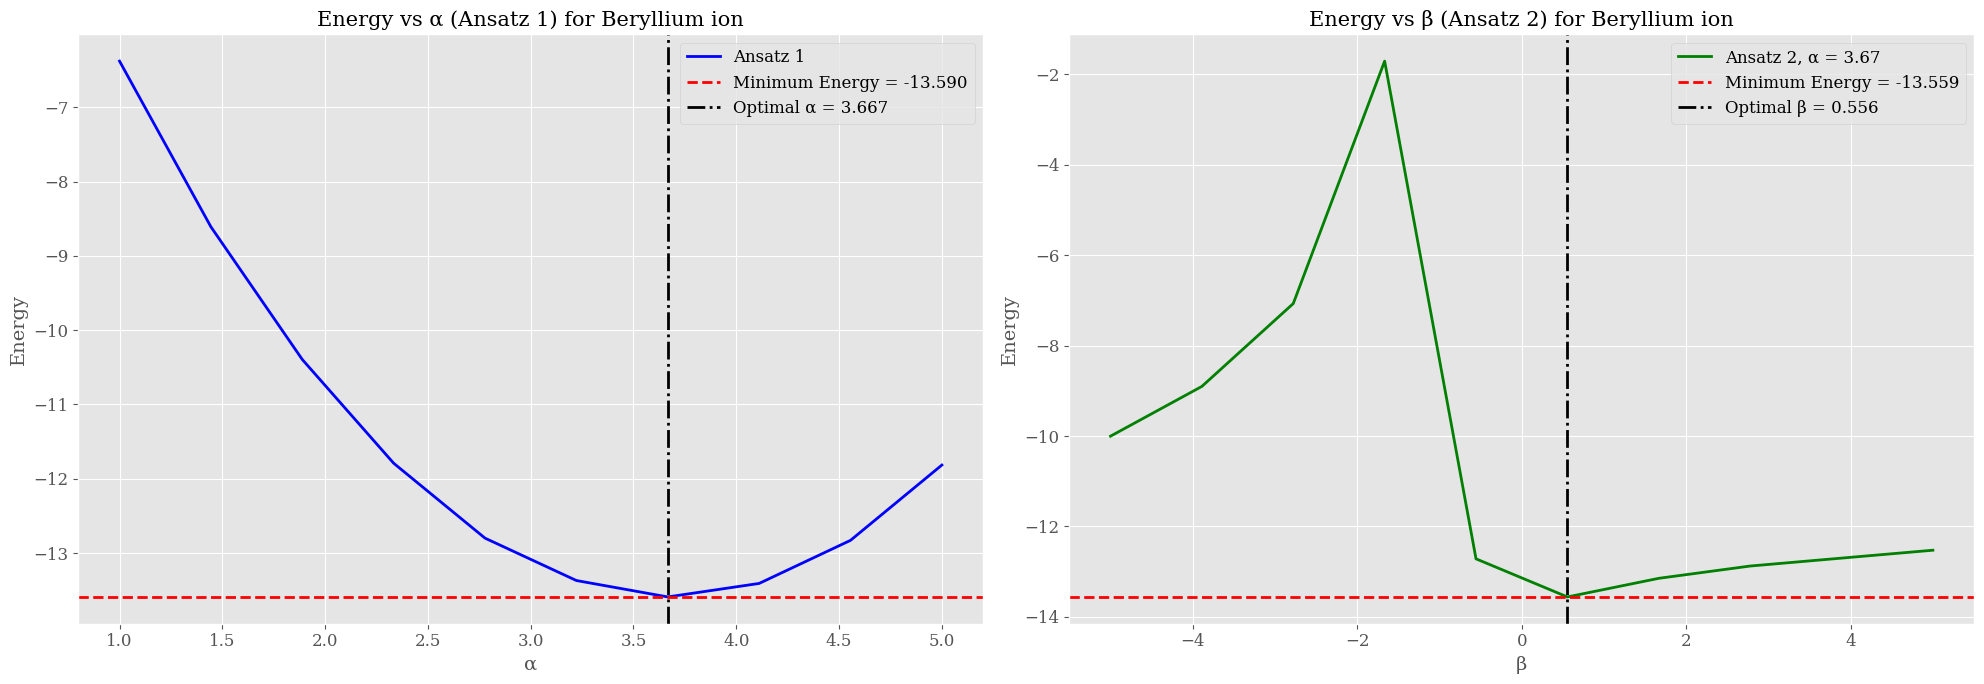

In [84]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.linewidth': 2,
})
plt.rcParams['text.usetex'] = False

fig, axs = plt.subplots(1, 2, figsize=(20, 7))

axs[0].plot(alpha_range, mean_energy_alpha, '-', label='Ansatz 1', color='blue')
axs[0].axhline(np.min(energies_alpha), color='red', linestyle='--',
               label=f'Minimum Energy = {np.min(energies_alpha):.3f}')
axs[0].axvline(optimal_alpha, linestyle='-.', color='black',
               label=f'Optimal α = {optimal_alpha:.3f}')
axs[0].set_xlabel('α')
axs[0].set_ylabel('Energy')
axs[0].set_title('Energy vs α (Ansatz 1) for Beryllium ion')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(beta_range, mean_energy_beta, label=f'Ansatz 2, α = {optimal_alpha:.2f}', color='green')
axs[1].axhline(np.min(energies_beta), color='red', linestyle='--',
               label=f'Minimum Energy = {np.min(energies_beta):.3f}')
axs[1].axvline(optimal_beta, linestyle='-.', color='black',
               label=f'Optimal β = {optimal_beta:.3f}')
axs[1].set_xlabel('β')
axs[1].set_ylabel('Energy')
axs[1].set_title('Energy vs β (Ansatz 2) for Beryllium ion')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()

print(f"Minimum energy: {np.min(energies_alpha):.6f} (in atomic units) or {4*13.6*np.min(energies_alpha):.6f} (in eV)")

In [85]:
#for ansatz 3
beta_vals = np.linspace(0.1, 4, 10)
energy_ansatz3 = []
variance_ansatz3 = []

for b in tqdm(beta_vals, unit='beta', desc='Optimizing beta'):
    _, energies = lightatoms_VMC(pos_initial, Z, step, samples=1000000, alpha=optimal_alpha, beta=b, ansatz=3)
    mean_e = np.mean(energies)
    energy_ansatz3.append(mean_e)
    variance_ansatz3.append(np.var(energies))

optimal_beta_ansatz3 = beta_vals[np.argmin(energy_ansatz3)]
print(f"Optimal beta from Ansatz 3 (using alpha={optimal_alpha:.4f}): {optimal_beta_ansatz3:.4f}")

Optimizing beta: 100%|██████████| 10/10 [28:48<00:00, 172.86s/beta]

Optimal beta from Ansatz 3 (using alpha=3.6667): 1.8333


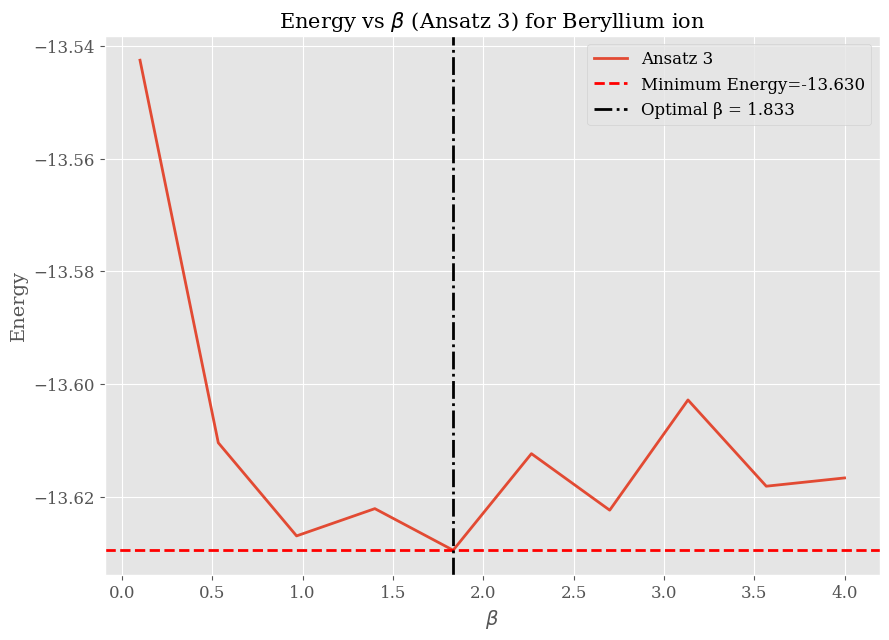

In [86]:
plt.figure(figsize=(10, 7))
plt.plot(beta_vals, energy_ansatz3, label='Ansatz 3')
plt.axhline(np.min(energy_ansatz3), color='red', linestyle='--', label=f'Minimum Energy={np.min(energy_ansatz3):.3f}')
plt.axvline(optimal_beta_ansatz3, linestyle='-.', color='black', label=f'Optimal β = {optimal_beta_ansatz3:.3f}')
plt.xlabel(r'$\beta$')
plt.ylabel('Energy')
plt.title(r'Energy vs $\beta$ (Ansatz 3) for Beryllium ion')
plt.legend()
plt.grid(True)

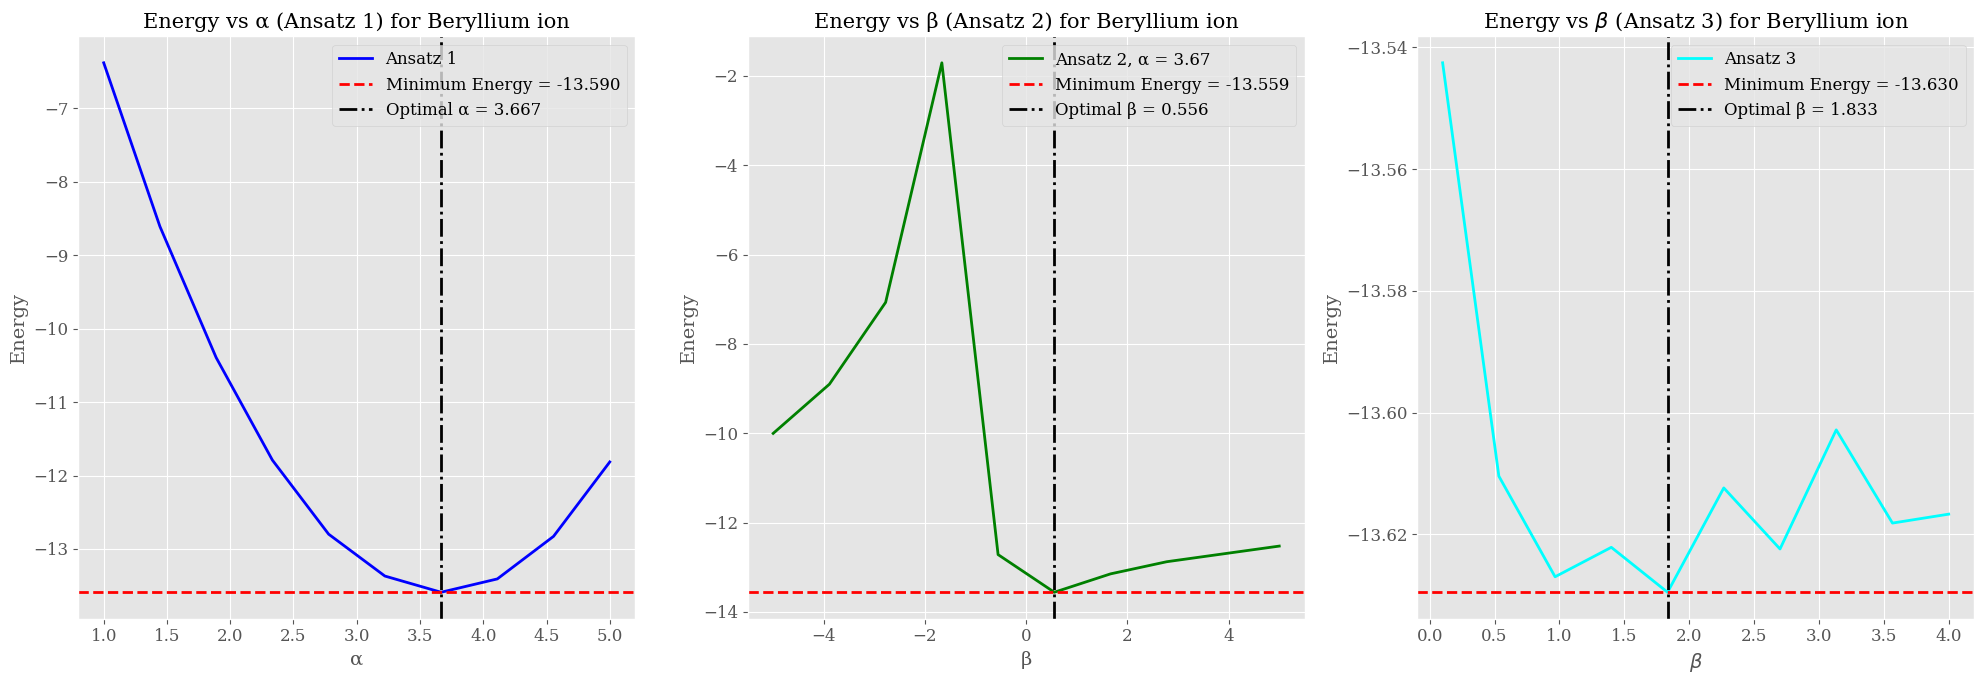

In [87]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.linewidth': 2,
})
plt.rcParams['text.usetex'] = False

fig, axs = plt.subplots(1,3, figsize=(20, 7))

axs[0].plot(alpha_range, mean_energy_alpha, '-', label='Ansatz 1', color='blue')
axs[0].axhline(np.min(energies_alpha), color='red', linestyle='--',
               label=f'Minimum Energy = {np.min(energies_alpha):.3f}')
axs[0].axvline(optimal_alpha, linestyle='-.', color='black',
               label=f'Optimal α = {optimal_alpha:.3f}')
axs[0].set_xlabel('α')
axs[0].set_ylabel('Energy')
axs[0].set_title('Energy vs α (Ansatz 1) for Beryllium ion')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(beta_range, mean_energy_beta, label=f'Ansatz 2, α = {optimal_alpha:.2f}', color='green')
axs[1].axhline(np.min(energies_beta), color='red', linestyle='--',
               label=f'Minimum Energy = {np.min(energies_beta):.3f}')
axs[1].axvline(optimal_beta, linestyle='-.', color='black',
               label=f'Optimal β = {optimal_beta:.3f}')
axs[1].set_xlabel('β')
axs[1].set_ylabel('Energy')
axs[1].set_title('Energy vs β (Ansatz 2) for Beryllium ion')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(beta_vals, energy_ansatz3, label='Ansatz 3', color='cyan', linestyle='-')
axs[2].axhline(np.min(energy_ansatz3), color='red', linestyle='--', label=f'Minimum Energy = {np.min(energy_ansatz3):.3f}')
axs[2].axvline(optimal_beta_ansatz3, linestyle='-.', color='black', label=f'Optimal β = {optimal_beta_ansatz3:.3f}')
axs[2].set_xlabel(r'$\beta$')
axs[2].set_ylabel('Energy')
axs[2].set_title(r'Energy vs $\beta$ (Ansatz 3) for Beryllium ion')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()

In [8]:
#2d plots for optimized alpha and beta for ansatz 2
alpha_values = np.linspace(3.6667 - 1.5, 3.6667 + 1.5, 5)
beta_values = np.linspace(0.556 - 0.4, 0.556 + 0.8, 7)
pos_initial = np.random.rand(2, 3)
energy_grid = np.zeros((len(alpha_values), len(beta_values)))
Z = 4
step = 0.15

for i, alpha in enumerate(tqdm(alpha_values, desc='Alpha', unit='alpha')):
    for j, beta in enumerate(beta_values):
        _, energies = lightatoms_VMC(pos_initial, 4, step, samples=10000, alpha=alpha, beta=beta, ansatz=2)
        energy_grid[i, j] = np.mean(energies)


Alpha: 100%|██████████| 5/5 [01:11<00:00, 14.36s/alpha]


In [9]:
min_idx = np.unravel_index(np.argmin(energy_grid), energy_grid.shape)
opt_alpha = alpha_values[min_idx[0]]
opt_beta = beta_values[min_idx[1]]
min_energy = energy_grid[min_idx]

print(f"Optimal parameters: α = {opt_alpha:.3f}, β = {opt_beta:.3f}")
print(f"Minimum energy: {min_energy:.6f} (in atomic units) or {4*13.6*min_energy:.6f} (in eV)")

Optimal parameters: α = 4.417, β = 0.756
Minimum energy: -13.770225 (in atomic units) or -749.100230 (in eV)


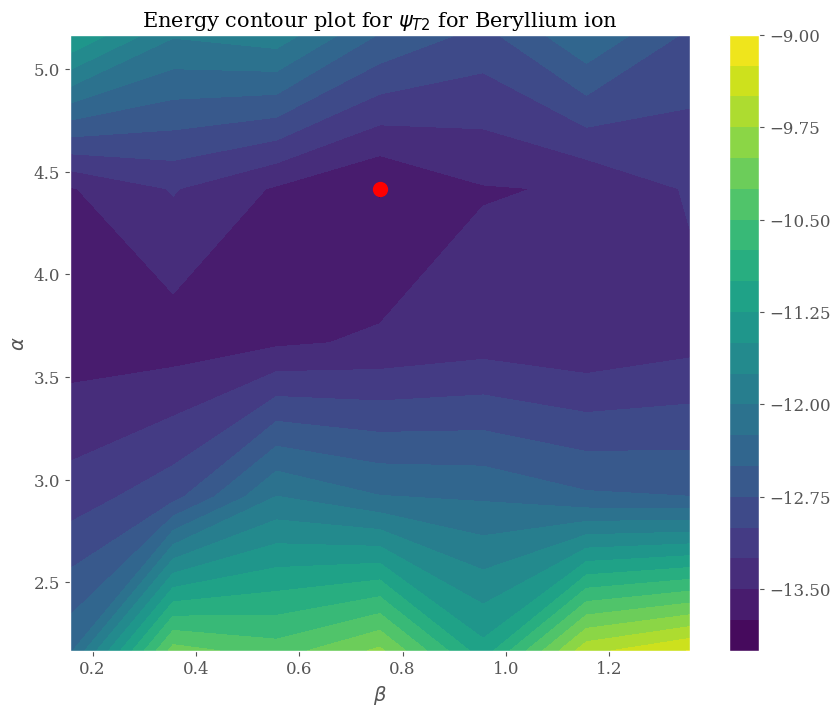

In [10]:
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('ggplot')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.linewidth': 2,
})
plt.rcParams['text.usetex'] = False
fig, ax = plt.subplots(figsize=(10, 8))
X, Y = np.meshgrid(beta_values, alpha_values)
contour = ax.contourf(X, Y, energy_grid, 20, cmap=cm.viridis)
fig.colorbar(contour, ax=ax)

ax.plot(opt_beta, opt_alpha, 'ro', markersize=10)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\alpha$')
ax.set_title('Energy contour plot for $\psi_{T2}$ for Beryllium ion')
plt.show()


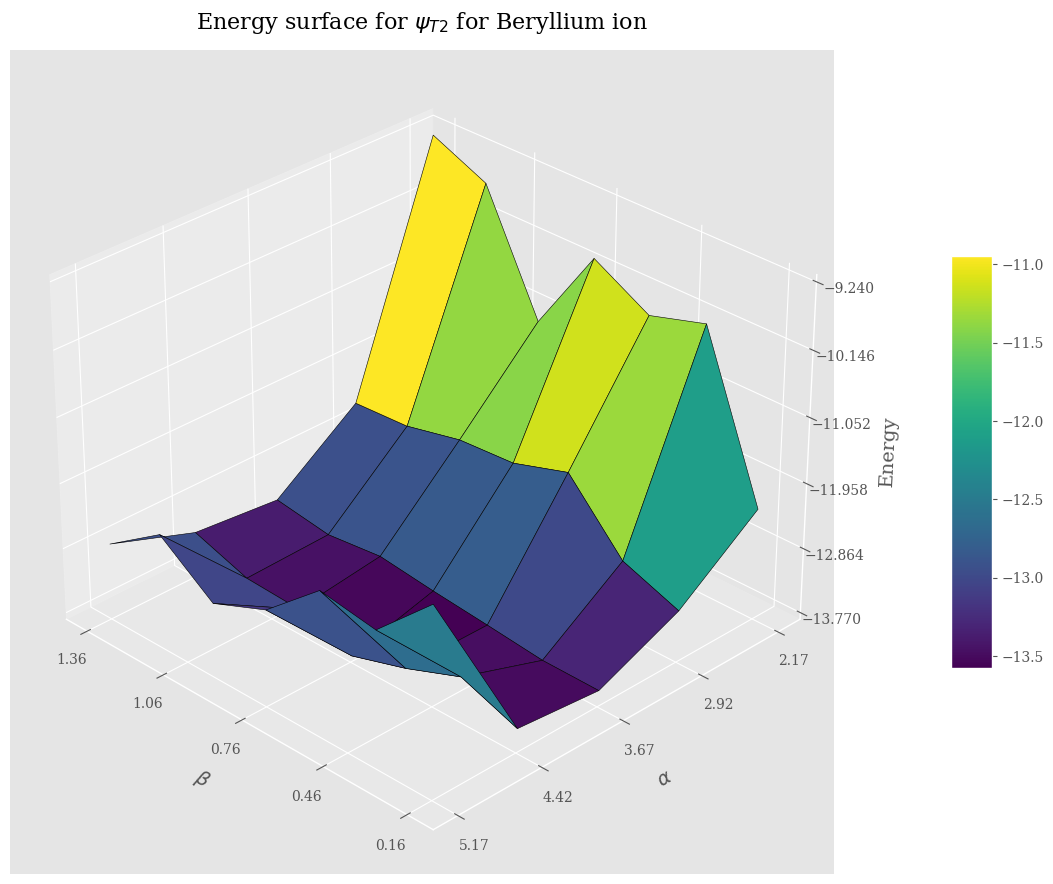

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

plt.style.use('ggplot')
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 1.8,
})

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, energy_grid, cmap=cm.viridis, edgecolor='k', linewidth=0.4, antialiased=True)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

ax.set_xlabel(r'$\beta$', labelpad=12)
ax.set_ylabel(r'$\alpha$', labelpad=12)
ax.set_zlabel('Energy', labelpad=12)

ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=5)
ax.zaxis.set_tick_params(pad=5)

ax.set_xticks(np.round(np.linspace(X.min(), X.max(), 5), 2))
ax.set_yticks(np.round(np.linspace(Y.min(), Y.max(), 5), 2))
ax.set_zticks(np.round(np.linspace(energy_grid.min(), energy_grid.max(), 6), 3))

ax.view_init(elev=30, azim=135)

ax.set_title('Energy surface for $\\psi_{T2}$ for Beryllium ion', pad=15)

plt.tight_layout()
plt.show()


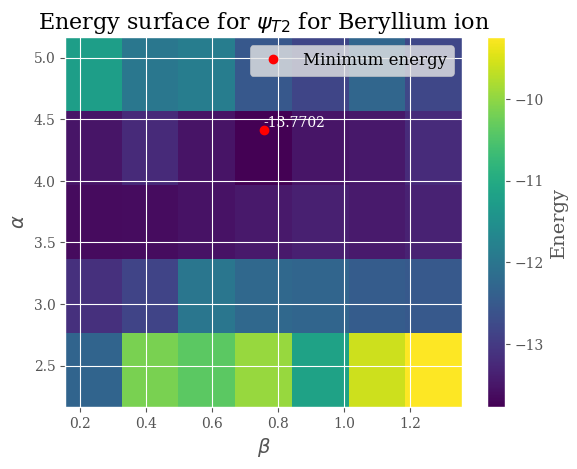

Minimum energy: -13.770225 a.u.
Optimal alpha: 4.416700
Optimal beta: 0.756000


In [12]:
import numpy as np
import matplotlib.pyplot as plt

min_index = np.unravel_index(np.argmin(energy_grid), energy_grid.shape)
min_alpha = alpha_values[min_index[0]]
min_beta = beta_values[min_index[1]]
min_energy = energy_grid[min_index]

plt.imshow(energy_grid, cmap='viridis',
           extent=[beta_values[0], beta_values[-1], alpha_values[0], alpha_values[-1]],
           origin='lower', aspect='auto')

plt.colorbar(label='Energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
plt.title('Energy surface for $\psi_{T2}$ for Beryllium ion')

plt.plot(min_beta, min_alpha, 'ro', label='Minimum energy')
plt.text(min_beta, min_alpha,
         f'{min_energy:.4f}', color='white', fontsize=10, ha='left', va='bottom')

plt.legend()
plt.show()

# Step 4: Print values
print(f"Minimum energy: {min_energy:.6f} a.u.")
print(f"Optimal alpha: {min_alpha:.6f}")
print(f"Optimal beta: {min_beta:.6f}")


In [31]:
#2d plots for optimized alpha and beta for ansatz 3
alpha_values = np.linspace(3.667 - 1.5, 3.667 + 1.5, 5)
beta_values = np.linspace(1.886 - 1.5, 1.886 + 3, 5)

energy_grid_ansatz3 = np.zeros((len(alpha_values), len(beta_values)))

for i, alpha in enumerate(tqdm(alpha_values, desc='Alpha', unit='alpha')):
    for j, beta in enumerate(beta_values):
        _, energies = lightatoms_VMC(pos_initial, 4, step, samples=10000, alpha=alpha, beta=beta, ansatz=3)
        energy_grid_ansatz3[i, j] = np.mean(energies)

Alpha: 100%|██████████| 5/5 [00:43<00:00,  8.74s/alpha]


In [32]:
min_idx = np.unravel_index(np.argmin(energy_grid_ansatz3), energy_grid_ansatz3.shape)
opt_alpha_ansatz3 = alpha_values[min_idx[0]]
opt_beta_ansatz3 = beta_values[min_idx[1]]
min_energy_ansatz3 = energy_grid_ansatz3[min_idx]

print(f"Optimal parameters: α = {opt_alpha_ansatz3:.3f}, β = {opt_beta_ansatz3:.3f}")
print(f"Minimum energy: {min_energy_ansatz3:.6f} (in atomic units) or {4*13.6*min_energy_ansatz3:.6f} (in eV)")

Optimal parameters: α = 3.667, β = 1.511
Minimum energy: -13.688063 (in atomic units) or -744.630617 (in eV)


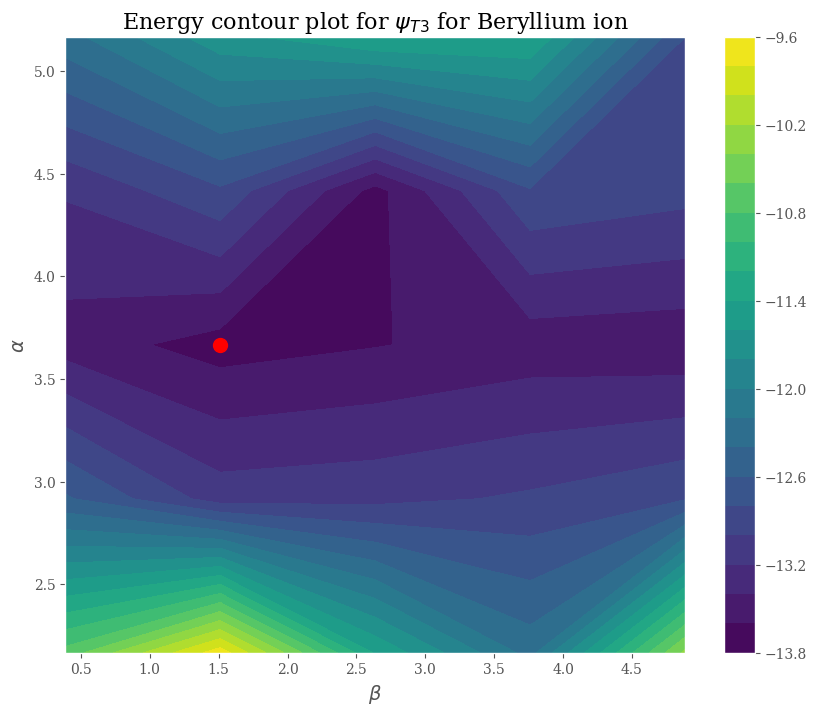

In [33]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, ax = plt.subplots(figsize=(10, 8))
X, Y = np.meshgrid(beta_values, alpha_values)
contour = ax.contourf(X, Y, energy_grid_ansatz3, 20, cmap=cm.viridis)
fig.colorbar(contour, ax=ax)

ax.plot(opt_beta_ansatz3, opt_alpha_ansatz3, 'ro', markersize=10)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\alpha$')
ax.set_title('Energy contour plot for $\psi_{T3}$ for Beryllium ion')
plt.show()


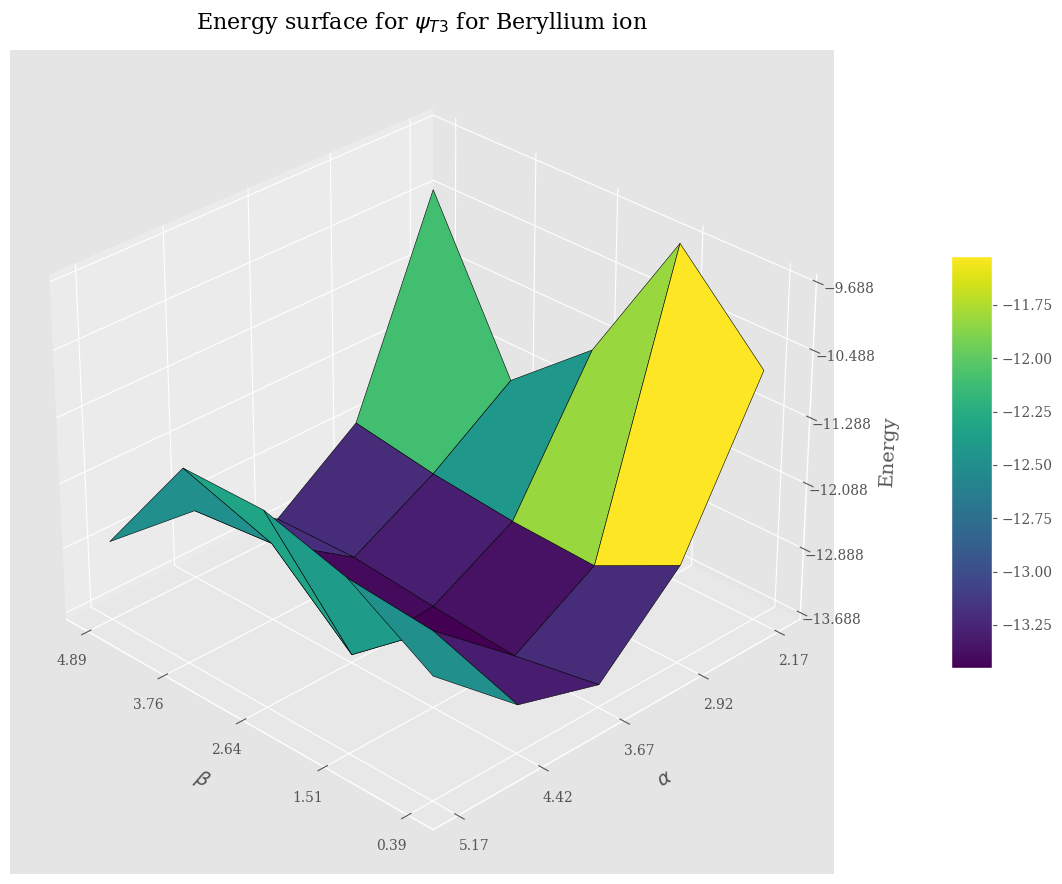

In [34]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, energy_grid_ansatz3, cmap=cm.viridis, edgecolor='k', linewidth=0.4, antialiased=True)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

ax.set_xlabel(r'$\beta$', labelpad=12)
ax.set_ylabel(r'$\alpha$', labelpad=12)
ax.set_zlabel('Energy', labelpad=12)

ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=5)
ax.zaxis.set_tick_params(pad=5)

ax.set_xticks(np.round(np.linspace(X.min(), X.max(), 5), 2))
ax.set_yticks(np.round(np.linspace(Y.min(), Y.max(), 5), 2))
ax.set_zticks(np.round(np.linspace(energy_grid_ansatz3.min(), energy_grid_ansatz3.max(), 6), 3))

ax.view_init(elev=30, azim=135)

ax.set_title('Energy surface for $\\psi_{T3}$ for Beryllium ion', pad=15)

plt.tight_layout()
plt.show()

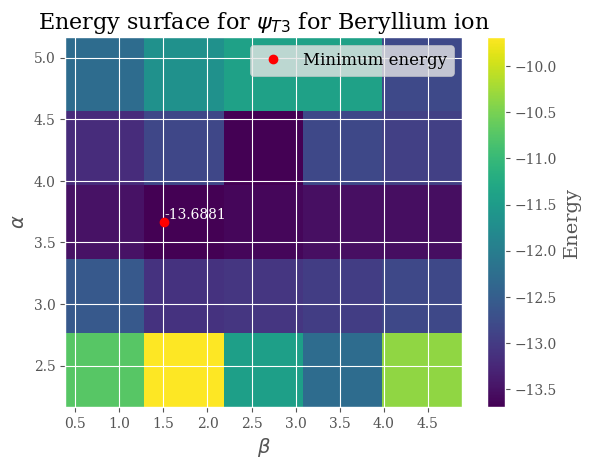

In [35]:
import numpy as np
import matplotlib.pyplot as plt

min_index = np.unravel_index(np.argmin(energy_grid_ansatz3), energy_grid_ansatz3.shape)
min_alpha = alpha_values[min_index[0]]
min_beta = beta_values[min_index[1]]
min_energy = energy_grid_ansatz3[min_index]

plt.imshow(energy_grid_ansatz3, cmap='viridis',
           extent=[beta_values[0], beta_values[-1], alpha_values[0], alpha_values[-1]],
           origin='lower', aspect='auto')

plt.colorbar(label='Energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
plt.title(r'Energy surface for $\psi_{T3}$ for Beryllium ion')

plt.plot(min_beta, min_alpha, 'ro', label='Minimum energy')
plt.text(min_beta, min_alpha,
         f'{min_energy:.4f}', color='white', fontsize=10, ha='left', va='bottom')

plt.legend()
plt.show()


In [36]:
print(f"Minimum energy: {min_energy:.6f} a.u.")
print(f"Optimal alpha: {min_alpha:.6f}")
print(f"Optimal beta: {min_beta:.6f}")

Minimum energy: -13.688063 a.u.
Optimal alpha: 3.667000
Optimal beta: 1.511000


# **Theoretical Values:**
Therefore, ansatz 3 turned out to be a better wavefunction for the description of Beryllium atom as well.

| Ion  | $Z$ | $E_0$ (a.u.) | $\langle r_{12} \rangle$ (a.u., approx) |
| ---- | --- | ------------ | --------------------------------------- |
| He   | 2   | −2.90372     | \~1.40                                |
| Li²⁺ | 3   | −7.27991     | \~0.97                                 |
| Be³⁺ | 4   | −13.65557    | \~0.75                                  |


# Experimental values:

| Parameter    | Ansatz 1      | Ansatz 2      | Ansatz 3      |
| ------------ | ------------- | ------------- | ------------- |
| $\alpha$     | 3.667      | 4.416700    |3.667000 |
| $\beta$      | —             | 0.756|1.511|
| $E_0$ (a.u.) | -13.590 a.u. | - -13.770225 a.u. | -13.688 a.u.|


In [37]:
alpha = 3.667
beta = 0
ansatz = 1

In [38]:
pos_initial = np.random.rand(2, 3)
position_saved_1, _ = lightatoms_VMC(pos_initial, Z=4, step=0.15, samples=100000, alpha=alpha, beta=beta, ansatz=ansatz)

In [39]:
import numpy as np

r12_values = [np.linalg.norm(p[0] - p[1]) for p in position_saved_1]
mean_r12 = np.mean(r12_values)
print(f"Mean inter-electronic distance <r12> = {mean_r12:.5f} a.u.")

Mean inter-electronic distance <r12> = 0.56874 a.u.


In [40]:
alpha = 4.4167
beta = 0.756
ansatz = 2

In [41]:
pos_initial = np.random.rand(2, 3)
position_saved_2, _ = lightatoms_VMC(pos_initial, Z=4, step=0.15, samples=100000, alpha=alpha, beta=beta, ansatz=ansatz)

In [42]:
import numpy as np

r12_values = [np.linalg.norm(p[0] - p[1]) for p in position_saved_2]
mean_r12 = np.mean(r12_values)
print(f"Mean inter-electronic distance <r12> = {mean_r12:.5f} a.u.")

Mean inter-electronic distance <r12> = 0.56593 a.u.


In [43]:
alpha = 3.667
beta = 1.511
ansatz = 3

In [44]:
pos_initial = np.random.rand(2, 3)
position_saved_3, _ = lightatoms_VMC(pos_initial, Z=4, step=0.15, samples=100000, alpha=alpha, beta=beta, ansatz=ansatz)

In [45]:
import numpy as np

r12_values = [np.linalg.norm(p[0] - p[1]) for p in position_saved_3]
mean_r12 = np.mean(r12_values)
print(f"Mean inter-electronic distance <r12> = {mean_r12:.5f} a.u.")

Mean inter-electronic distance <r12> = 0.61317 a.u.
